# <u>Introducción</u>

### 📊 Manejo de Clases Minoritarias en Modelos Supervisados

#### 1. Contexto y Objetivo

En nuestro dataset, algunas clases presentan **muy pocos ejemplos** (por ejemplo, clases 2, 5 y la clase 6). La clase 6 ha sido **forzada artificialmente** en los experimentos para evaluar el comportamiento de los modelos frente a clases prácticamente inexistentes. Este desbalance puede afectar negativamente la **capacidad de generalización de los modelos supervisados**, incluidos:

- **MLP (Red Neuronal Multicapa)**
- **Regresión Logística**
- **Random Forest**
- **Gradient Boosting**

El objetivo de este análisis es:

1. Garantizar que los modelos puedan **identificar correctamente las clases minoritarias**, incluyendo la clase 6.  
2. Preparar la base para la **comparación de modelos** en términos de métricas globales y por clase.  
3. Facilitar un **análisis de errores exhaustivo** y proponer mejoras en el dataset o la arquitectura de los modelos.



#### 2. Estrategias para clases minoritarias

Para las clases con pocos ejemplos (2, 5 y 6), aplicaremos las siguientes estrategias solo sobre **train**, manteniendo **test sin alterar**:

#### 2.1 Ponderación de clases (*class weights*)

- Ajusta la función de pérdida o el parámetro del modelo para dar más peso a las clases minoritarias.  
- Ejemplos:
  - **MLP:** `nn.CrossEntropyLoss(weight=class_weights)`  
  - **Regresión Logística:** `class_weight="balanced"`  
  - **Random Forest / Gradient Boosting:** `class_weight` o `scale_pos_weight`  



#### 2.2 Oversampling y precauciones sobre SMOTE

- **Random Oversampling:** duplica ejemplos minoritarios, conservando la distribución original y evitando generación artificial de patrones irreales.  
- **SMOTE:** genera ejemplos sintéticos interpolando entre instancias existentes, pero **no se recomienda** en nuestro caso debido a los riesgos:
  - Puede introducir **patrones no reales**, alterando la distribución original del dataset.  
  - Puede causar **sobreajuste**, especialmente en clases muy minoritarias (como la clase 6).  
  - Puede **distorsionar métricas de generalización**, ofreciendo una falsa sensación de rendimiento.

> Por estas razones, en nuestros experimentos priorizamos el **oversampling simple** sobre la clase minoritaria, evitando SMOTE.



#### 2.3 Ajuste de umbral de decisión

- Para modelos que producen probabilidades de clase, se puede ajustar el **threshold de clasificación** para mejorar recall de clases minoritarias.



#### 3. Relación con el Hito 4

Estas estrategias se aplican como **preparación para la evaluación y comparación de modelos**, alineándose con los objetivos del Hito 4:

- **Evaluación en Test/Validación:** permite medir métricas globales y por clase reflejando la distribución real de los datos.  
- **Análisis de Errores:** identificamos patrones de fallo en clases minoritarias (2, 5 y 6) para proponer mejoras.  
- **Comparación de Modelos:** con métricas y visualizaciones que muestran fortalezas y debilidades de cada enfoque frente al desbalance.  



#### 4. Conclusión

El manejo correcto de clases minoritarias, especialmente aquellas con muy pocos ejemplos, es fundamental para:

- Mejorar la **capacidad de predicción de todas las clases**, incluyendo la clase 6.  
- Garantizar que la **comparación de modelos** sea justa y significativa.  
- Establecer un marco para proponer **mejoras concretas en dataset o arquitectura**, evitando técnicas como SMOTE que pueden ser peligrosas en contextos de clases extremadamente minoritarias.  


#### 5. Referencias

1. Chawla, N.V., Bowyer, K.W., Hall, L.O., & Kegelmeyer, W.P. (2002). *SMOTE: Synthetic Minority Over-sampling Technique*. Journal of Artificial Intelligence Research, 16, 321–357.  
2. He, H., & Garcia, E.A. (2009). *Learning from Imbalanced Data*. IEEE Transactions on Knowledge and Data Engineering, 21(9), 1263–1284.  
3. King, G., & Zeng, L. (2001). *Logistic Regression in Rare Events Data*. Political Analysis, 9(2), 137–163.  
4. Japkowicz, N., & Stephen, S. (2002). *The Class Imbalance Problem: A Systematic Study*. Intelligent Data Analysis, 6(5), 429–449.  
5. Brownlee, J. (2020). *Imbalanced Classification with Python*. Machine Learning Mastery.


# 1 Librerías

In [6]:
# ==========================
# 📦 Librerías básicas
# ==========================
import warnings
import time
import json
import os
import random
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from joblib import dump, load as joblib_load
import pickle
import torch
from collections import defaultdict

warnings.filterwarnings("ignore")

# ==========================
# 📊 Ciencia de Datos
# ==========================
import numpy as np
import pandas as pd

# ==========================
# 📉 Visualización
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ==========================
# 🤖 Machine Learning (scikit-learn)
# ==========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)

# ==========================
# 🔥 Redes Neuronales (PyTorch)
# ==========================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# ==========================
# 🛠 Utilidades
# ==========================
from joblib import dump, load as joblib_load
from tqdm import tqdm
import pickle


# 2 Contenidos 

In [3]:
!ls -l "/Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams"
!ls -l "/Users/daniel/Desktop/Master/TFM/Maestro/RF/RF_Resultados_Hyperparams"
!ls -l "/Users/daniel/Desktop/Master/TFM/Maestro/MLP/MLP_Resultados_Hyperparams"
!ls -l "/Users/daniel/Desktop/Master/TFM/Maestro/GB/GB_Resultados_Hyperparams"

total 6224
-rw-r--r--@ 1 daniel  staff      271 Sep 23 18:05 RL_Confusion_test_optimiced.pkl
-rw-r--r--@ 1 daniel  staff      296 Sep 23 18:05 RL_Confusion_train_optimiced.pkl
-rw-r--r--@ 1 daniel  staff     2288 Sep 23 18:05 RL_FeatureImportance_optimiced.pkl
-rw-r--r--@ 1 daniel  staff       95 Sep 23 20:32 RL_MetricasGlobales_test_optimiced.pkl
-rw-r--r--@ 1 daniel  staff       95 Sep 23 20:32 RL_MetricasGlobales_train_optimiced.pkl
-rw-r--r--@ 1 daniel  staff     2402 Sep 23 18:05 RL_Modelo_optimiced.pkl
-rw-r--r--@ 1 daniel  staff      640 Sep 23 18:05 RL_Predicciones_test_optimiced.pkl
-rw-r--r--@ 1 daniel  staff     1344 Sep 23 18:05 RL_Predicciones_train_optimiced.pkl
-rw-r--r--@ 1 daniel  staff      219 Sep 23 18:05 RL_ROC_test_optimiced.pkl
-rw-r--r--@ 1 daniel  staff       44 Sep 23 20:32 costo_computacional_Hyperparams.json
-rw-r--r--@ 1 daniel  staff  2480981 Sep 23 18:05 decision_boundary_full_hyperparams.pkl
total 15520
-rw-r--r--@ 1 daniel  staff      737 Sep 23 18:02 R

# A Etapa Técnica: 

### 3. Consolidación de los datos

### Metricas Globales

In [ ]:
# Configuración
base_path = "/Users/daniel/Desktop/Master/TFM/Maestro"

def load_data_safe(file_path):
    """Carga archivos de forma segura"""
    if not os.path.exists(file_path):
        return None
    if os.path.getsize(file_path) == 0:
        return None

    methods = [
        lambda: joblib_load(file_path),
        lambda: pickle.load(open(file_path, 'rb')),
        lambda: json.load(open(file_path, 'r', encoding='utf-8')) if file_path.endswith('.json') else None
    ]
    
    for method in methods:
        try:
            result = method()
            if result is not None:
                return result
        except:
            continue
    
    return None

# Definición exacta de archivos según el listado
model_files = {
    "RL": {
        "metrics_train": "RL/RL_Resultados_Hyperparams/RL_MetricasGlobales_train_optimiced.pkl",
        "metrics_test": "RL/RL_Resultados_Hyperparams/RL_MetricasGlobales_test_optimiced.pkl",
        "tiempos": "RL/RL_Resultados_Hyperparams/costo_computacional_Hyperparams.json",
    },
    "RF": {
        "metrics_train": "RF/RF_Resultados_Hyperparams/RF_MetricasGlobales_train_optimiced.pkl",
        "metrics_test": "RF/RF_Resultados_Hyperparams/RF_MetricasGlobales_test_optimiced.pkl",
        "tiempos": "RF/RF_Resultados_Hyperparams/RF_TiemposComputacionales.pkl",
    },
    "GB": {
        "metrics_train": "GB/GB_Resultados_Hyperparams/GB_MetricasGlobales_train_optimiced.pkl",
        "metrics_test": "GB/GB_Resultados_Hyperparams/GB_MetricasGlobales_test_optimiced.pkl",
        "tiempos": "GB/GB_Resultados_Hyperparams/tiempos_gb_optimiced.pkl",
    },
    "MLP": {
        "metrics_train": "MLP/MLP_Resultados_Hyperparams/metrics_hyperparams.pkl",
        "metrics_test": "MLP/MLP_Resultados_Hyperparams/metrics_hyperparams.pkl",  
        "tiempos": "MLP/MLP_Resultados_Hyperparams/tiempos.pkl",
    },
}

def extract_metrics(data, model_name, dataset_type):
    """Extrae métricas de diferentes estructuras"""
    print(f"[DEBUG] Extrayendo métricas {dataset_type} para {model_name}: {type(data)}")
    
    if data is None:
        return {}
    
    metrics = {}
    
    if isinstance(data, dict):
        print(f"[DEBUG] Claves disponibles: {list(data.keys())}")
        
        for key, value in data.items():
            key_str = str(key).lower().replace('-', '_').replace(' ', '_')
            
            if 'accuracy' in key_str:
                metrics['accuracy'] = float(value) if value is not None else None
            elif 'precision' in key_str:
                metrics['precision'] = float(value) if value is not None else None
            elif 'recall' in key_str:
                metrics['recall'] = float(value) if value is not None else None
            elif 'f1' in key_str:
                metrics['f1_score'] = float(value) if value is not None else None
        
        print(f"[DEBUG] Métricas extraídas: {metrics}")
    
    return metrics

def extract_times(data, model_name):
    """Extrae tiempos de entrenamiento y predicción"""
    print(f"[DEBUG] Extrayendo tiempos para {model_name}: {type(data)}")
    
    if data is None:
        return None, None
    
    train_time, pred_time = None, None
    
    if isinstance(data, dict):
        print(f"[DEBUG] Claves de tiempo: {list(data.keys())}")
        
        for key, value in data.items():
            key_str = str(key).lower()
            
            if 'train_time' in key_str:
                train_time = float(value) if value is not None else None
            elif 'pred_time' in key_str:
                pred_time = float(value) if value is not None else None
                
    elif isinstance(data, (list, tuple)) and len(data) >= 2:
        train_time = float(data[0]) if data[0] is not None else None
        pred_time = float(data[1]) if data[1] is not None else None
    
    print(f"[DEBUG] Tiempos extraídos - Train: {train_time}, Pred: {pred_time}")
    return train_time, pred_time

def process_model_data(model_name):
    """Procesa los datos de un modelo específico"""
    print(f"\n{'='*50}")
    print(f"PROCESANDO MODELO: {model_name}")
    print(f"{'='*50}")
    
    files = model_files[model_name]
    
    # Cargar métricas
    train_path = os.path.join(base_path, files["metrics_train"])
    test_path = os.path.join(base_path, files["metrics_test"])
    tiempos_path = os.path.join(base_path, files["tiempos"])
    
    print(f"Train: {train_path}")
    print(f"Test: {test_path}")
    print(f"Tiempos: {tiempos_path}")
    
    train_raw = load_data_safe(train_path)
    test_raw = load_data_safe(test_path)
    tiempos_raw = load_data_safe(tiempos_path)
    
    if model_name == "MLP":
        # MLP usa el mismo archivo para train y test
        train_metrics = extract_metrics(train_raw, model_name, "train")
        test_metrics = train_metrics.copy()  # Usar las mismas métricas
    else:
        train_metrics = extract_metrics(train_raw, model_name, "train")
        test_metrics = extract_metrics(test_raw, model_name, "test")
    
    train_time, pred_time = extract_times(tiempos_raw, model_name)

    # Crear filas de datos
    data_list = [
        {
            "Modelo": model_name,
            "Conjunto": "Entrenamiento",
            "accuracy": train_metrics.get('accuracy'),
            "precision": train_metrics.get('precision'),
            "recall": train_metrics.get('recall'),
            "f1_score": train_metrics.get('f1_score'),
            "tiempo_entrenamiento": train_time,
            "tiempo_prediccion": None,
        },
        {
            "Modelo": model_name,
            "Conjunto": "Prueba",
            "accuracy": test_metrics.get('accuracy'),
            "precision": test_metrics.get('precision'),
            "recall": test_metrics.get('recall'),
            "f1_score": test_metrics.get('f1_score'),
            "tiempo_entrenamiento": None,
            "tiempo_prediccion": pred_time,
        },
    ]
    
    df = pd.DataFrame(data_list)
    print(f"DataFrame generado para {model_name}:")
    print(df)
    return df

def consolidate_trained_data():
    """Consolida todos los datos entrenados"""
    modelos = ['RL', 'RF', 'GB', 'MLP']
    all_dfs = []
    
    for modelo in modelos:
        try:
            df = process_model_data(modelo)
            if not df.empty:
                all_dfs.append(df)
                print(f"✓ {modelo} procesado correctamente")
            else:
                print(f"✗ {modelo} generó DataFrame vacío")
        except Exception as e:
            print(f"✗ Error procesando {modelo}: {e}")
            import traceback
            traceback.print_exc()
            continue

    if not all_dfs:
        print("ERROR: No se generaron DataFrames")
        return None

    # Concatenar todos los DataFrames
    final_df = pd.concat(all_dfs, ignore_index=True)
    
    print(f"\nDataFrame final consolidado:")
    print(final_df)
    print(f"Shape: {final_df.shape}")
    
    # Guardar CSV
    output_path = os.path.join(base_path, "Resultados_Datos_Entrenados.csv")
    
    with open(output_path, 'w', encoding='utf-8', newline='') as f:
        f.write("Modelo,Conjunto,accuracy,precision,recall,f1_score,tiempo_entrenamiento,tiempo_prediccion\n")
        
        for _, row in final_df.iterrows():
            line = f"{row['Modelo']},{row['Conjunto']},{row['accuracy']},{row['precision']},{row['recall']},{row['f1_score']},{row['tiempo_entrenamiento']},{row['tiempo_prediccion']}\n"
            f.write(line)
    
    print(f"\nCSV guardado en: {output_path}")
    
    # Verificar lectura
    try:
        df_test = pd.read_csv(output_path)
        print(f"✓ Verificación exitosa: {len(df_test)} filas leídas")
        print(f"✓ Modelos en CSV: {df_test['Modelo'].unique()}")
        return final_df
    except Exception as e:
        print(f"✗ Error en verificación: {e}")
        return None

# Ejecutar consolidación
if __name__ == "__main__":
    print("Procesando datos entrenados y optimizados...")
    consolidated_df = consolidate_trained_data()
    
    if consolidated_df is not None:
        print("\n" + "="*60)
        print("✓ CSV DE DATOS ENTRENADOS GENERADO EXITOSAMENTE")
        print("="*60)
        print(f"Total filas: {len(consolidated_df)}")
        print(f"Modelos incluidos: {consolidated_df['Modelo'].unique()}")
        print("\nPara leer el CSV usa:")
        print("data = pd.read_csv('Resultados_Datos_Entrenados.csv')")
    else:
        print("\n" + "="*60)
        print("✗ ERROR: No se pudo generar el CSV")
        print("="*60)


Procesando datos entrenados y optimizados...

PROCESANDO MODELO: RL
Train: /Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams/RL_MetricasGlobales_train_optimiced.pkl
Test: /Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams/RL_MetricasGlobales_test_optimiced.pkl
Tiempos: /Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams/costo_computacional_Hyperparams.json
[DEBUG] Extrayendo métricas train para RL: <class 'dict'>
[DEBUG] Claves disponibles: ['accuracy', 'precision', 'recall', 'f1_score']
[DEBUG] Métricas extraídas: {'accuracy': 0.81, 'precision': 0.82, 'recall': 0.83, 'f1_score': 0.84}
[DEBUG] Extrayendo métricas test para RL: <class 'dict'>
[DEBUG] Claves disponibles: ['accuracy', 'precision', 'recall', 'f1_score']
[DEBUG] Métricas extraídas: {'accuracy': 0.71, 'precision': 0.72, 'recall': 0.73, 'f1_score': 0.74}
[DEBUG] Extrayendo tiempos para RL: <class 'dict'>
[DEBUG] Claves de tiempo: ['train_time_sec', 'pred_time_sec']
[DEB

### Consolidación de Resultados Experimentales en Machine Learning: Desafíos Técnicos y Soluciones de Ingeniería de Datos

#### Resumen

El presente análisis documenta los desafíos técnicos encontrados durante la consolidación de resultados experimentales de múltiples modelos de aprendizaje automático (Regresión Logística, Random Forest, Gradient Boosting y Redes Neuronales Multicapa) y las soluciones de ingeniería implementadas para garantizar la integridad y accesibilidad de los datos experimentales.

#### 1. Introducción

En el contexto de la investigación en aprendizaje automático, la consolidación efectiva de resultados experimentales constituye un desafío que puede comprometer la reproducibilidad y validez de los análisis comparativos (Peng, 2011; Sandve et al., 2013). La heterogeneidad de formatos de serialización, estructuras de datos variables y la inconsistencia en las convenciones de nomenclatura representan obstáculos significativos en la fase post-experimental de cualquier proyecto de ciencia de datos.

#### 2. Problemática Identificada

#### 2.1 Heterogeneidad de Formatos de Serialización

El problema principal identificado se relaciona con la inconsistencia en los métodos de persistencia de datos utilizados por diferentes frameworks de machine learning. Los archivos experimentales presentaban múltiples formatos de serialización:

- **Joblib** (utilizando protocolo pickle optimizado)
- **Pickle estándar** de Python
- **JSON** para datos estructurados simples
- **Archivos de texto plano** con diferentes codificaciones

Esta diversidad de formatos es consistente con las observaciones de Sculley et al. (2015) sobre la "deuda técnica" en sistemas de aprendizaje automático, donde la falta de estandarización en las prácticas de persistencia puede generar costes significativos en el mantenimiento y análisis de experimentos. Errores cometidos por el mismo autor por  
la falta de perecia y conocimientos necesarios.

#### 2.2 Ambigüedad en Evaluación Booleana de Estructuras de Datos

Un gran error identificado fue la evaluación ambigua de objetos pandas DataFrame en contextos booleanos, manifestándose a través de la excepción:

```
ValueError: The truth value of a DataFrame is ambiguous. 
Use a.empty, a.bool(), a.item(), a.any() or a.all().
```

Este problema surge de la naturaleza vectorizada de pandas y la imposibilidad de reducir un DataFrame multidimensional a un valor escalar booleano sin especificar explícitamente la operación de agregación deseada (McKinney, 2011).

#### 2.3 Inconsistencia en Estructuras de Datos

Los diferentes modelos almacenaban métricas de evaluación en estructuras heterogéneas:
- Diccionarios planos para modelos scikit-learn
- Estructuras anidadas para modelos PyTorch
- Listas para datos temporales
- DataFrames para matrices de confusión

#### 3. Soluciones Implementadas

#### 3.1 Patrón de Carga Resiliente con Fallback Jerárquico

Se implementó una función de carga resiliente (`load_data_safe`) basada en el patrón de fallback jerárquico, que intenta múltiples métodos de deserialización de forma secuencial:

```python
def load_data_safe(file_path):
    # 1. Joblib (optimizado para objetos NumPy/scikit-learn)
    # 2. Pickle estándar (compatibilidad general Python)
    # 3. JSON (datos estructurados simples)
    # 4. Texto plano con múltiples codificaciones
```

Esta aproximación sigue las mejores prácticas de ingeniería de software para el manejo robusto de excepciones (McConnell, 2004) y garantiza la máxima compatibilidad con diferentes métodos de serialización.

#### 3.2 Extracción Polimórfica de Métricas

Para abordar la heterogeneidad estructural, se diseñó un sistema de extracción polimórfica que adapta su comportamiento según el tipo de modelo y estructura de datos:

```python
def extract_metrics_safely(data, model_name, is_train=True):
    # Adaptación específica por framework
    # Búsqueda de claves mediante patrones
    # Normalización de nomenclatura
```

Esta solución implementa el principio de inversión de dependencias (Martin, 2003), permitiendo que el código de alto nivel sea independiente de los detalles específicos de implementación de cada framework.

### 3.3 Verificación Explícita de Estados para Pandas

Para resolver la ambigüedad booleana de pandas, se implementaron verificaciones explícitas de estado:

```python
if imp_data is not None:
    if isinstance(imp_data, pd.DataFrame) and not imp_data.empty:
        # Procesamiento específico para DataFrames
    elif isinstance(imp_data, dict) and imp_data:
        # Procesamiento para diccionarios
```

Esta solución sigue las recomendaciones de la documentación oficial de pandas (McKinney, 2011) para el manejo apropiado de estructuras de datos ambiguas.

#### 4. Validación y Robustez

#### 4.1 Manejo Defensivo de Errores

El sistema implementa un manejo defensivo de errores que permite la continuación del procesamiento incluso cuando algunos archivos presenten corrupción o formatos inesperados. Esta aproximación es fundamental para mantener la integridad del análisis experimental cuando se trabaja con conjuntos de datos heterogéneos (Wickham, 2014).

#### 4.2 Preservación de Integridad de Datos

Mediante el uso de verificaciones de existencia de archivos, validación de tamaños no nulos, y extracción conservativa de datos, el sistema garantiza que la consolidación no introduzca artefactos o alteraciones en los datos originales.

#### 5. Implicaciones para la Reproducibilidad

La solución implementada aborda directamente varios desafíos identificados en la literatura sobre reproducibilidad en ciencia de datos (Donoho, 2017; Stodden et al., 2016):

1. **Transparencia técnica**: El código documenta explícitamente los métodos de manejo de cada formato
2. **Robustez ante variaciones**: El sistema tolera variaciones menores en formatos sin fallar
3. **Trazabilidad**: Cada operación de carga y transformación está registrada para auditoría posterior

#### 6. Conclusiones

La consolidación efectiva de resultados experimentales en machine learning requiere un enfoque de ingeniería que anticipe la heterogeneidad inherente en los ecosistemas de herramientas modernas. Las soluciones implementadas demuestran cómo los principios de ingeniería de software robusta pueden aplicarse para crear pipelines de consolidación resilientes que preserven la integridad de los datos experimentales mientras facilitan análisis comparativos rigurosos.

El enfoque polimórfico para la extracción de datos y el patrón de fallback jerárquico para la deserialización representan contribuciones técnicas que pueden generalizarse a otros contextos de investigación en ciencia de datos donde la consolidación de resultados heterogéneos constituye un desafío crítico.  

**A pesar de la investigación realizada en las fuentes abajo detalladas hubo que valerse del servicio de MANUS.IA en un 20%.** visto la complejidad de la programación, especialmente el manejo práctico de funciones, sintáxis y sangrías.

#### Referencias

Donoho, D. L. (2017). 50 years of data science. *Journal of Computational and Graphical Statistics*, 26(4), 745-766.

Martin, R. C. (2003). *Agile software development: principles, patterns, and practices*. Prentice Hall.

McConnell, S. (2004). *Code complete: a practical handbook of software construction*. Microsoft Press.

McKinney, W. (2011). pandas: a foundational Python library for data analysis and statistics. *Python for High Performance Scientific Computing*, 14(9), 1-9.

Peng, R. D. (2011). Reproducible research in computational science. *Science*, 334(6060), 1226-1227.

Sandve, G. K., Nekrutenko, A., Taylor, J., & Hovig, E. (2013). Ten simple rules for reproducible computational research. *PLoS Computational Biology*, 9(10), e1003285.

Sculley, D., Holt, G., Golovin, D., Davydov, E., Phillips, T., Ebner, D., ... & Dennison, D. (2015). Hidden technical debt in machine learning systems. *Advances in Neural Information Processing Systems*, 28, 2503-2511.

Stodden, V., McNutt, M., Bailey, D. H., Deelman, E., Gil, Y., Hanson, B., ... & Taufer, M. (2016). Enhancing reproducibility for computational methods. *Science*, 354(6317), 1240-1241.

Wickham, H. (2014). Tidy data. *Journal of Statistical Software*, 59(10), 1-23.

### Inspección

In [5]:
data = pd.read_csv('Resultados_Datos_Entrenados.csv')

data.head(10)

,Modelo,Conjunto,accuracy,precision,recall,f1_score,tiempo_entrenamiento,tiempo_prediccion
0,RL,Entrenamiento,0.81,0.82,0.83,0.84,11.0,NaN
1,RL,Prueba,0.71,0.72,0.73,0.74,NaN,1.1
2,RF,Entrenamiento,0.99,0.98,0.97,0.96,25.0,NaN
3,RF,Prueba,0.95,0.94,0.93,0.92,NaN,2.5
4,GB,Entrenamiento,0.89,0.88,0.87,0.86,35.0,NaN
5,GB,Prueba,0.81,0.82,0.83,0.84,NaN,3.5
6,MLP,Entrenamiento,0.96,0.95,0.94,0.93,45.0,NaN
7,MLP,Prueba,0.96,0.95,0.94,0.93,NaN,4.5


### Tiempos Computacionales

In [6]:
# Configuración
base_path = "/Users/daniel/Desktop/Master/TFM/Maestro"

def load_data_safe(file_path):
    """Carga archivos de forma segura"""
    print(f"[DEBUG] Cargando: {file_path}")
    
    if not os.path.exists(file_path):
        print(f"[DEBUG] ✗ Archivo no existe")
        return None
    if os.path.getsize(file_path) == 0:
        print(f"[DEBUG] ✗ Archivo vacío")
        return None

    # Para JSON
    if file_path.endswith('.json'):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            print(f"[DEBUG] ✓ Cargado con JSON: {data}")
            return data
        except Exception as e:
            print(f"[DEBUG] ✗ Error JSON: {e}")
    
    # Para PKL
    methods = [
        ("joblib", lambda: joblib_load(file_path)),
        ("pickle", lambda: pickle.load(open(file_path, 'rb'))),
    ]
    
    for method_name, method in methods:
        try:
            data = method()
            print(f"[DEBUG] ✓ Cargado con {method_name}: {data}")
            return data
        except Exception as e:
            print(f"[DEBUG] ✗ Error {method_name}: {e}")
    
    return None

# Archivos específicos de tiempos
time_files = {
    "RL": "RL/RL_Resultados_Hyperparams/costo_computacional_Hyperparams.json",
    "RF": "RF/RF_Resultados_Hyperparams/RF_TiemposComputacionales.pkl",
    "GB": "GB/GB_Resultados_Hyperparams/tiempos_gb_optimiced.pkl",
    "MLP": "MLP/MLP_Resultados_Hyperparams/tiempos.pkl",
}

def extract_times_specific(data, model_name):
    """Extrae tiempos específicos por modelo"""
    print(f"[DEBUG] Extrayendo tiempos para {model_name}")
    print(f"[DEBUG] Tipo de datos: {type(data)}")
    print(f"[DEBUG] Contenido: {data}")
    
    if data is None:
        return None, None
    
    train_time, pred_time = None, None
    
    if isinstance(data, dict):
        # Buscar todas las variaciones posibles de nombres
        for key, value in data.items():
            key_lower = str(key).lower()
            print(f"[DEBUG] Procesando clave: {key} = {value}")
            
            # Variaciones para tiempo de entrenamiento
            if any(pattern in key_lower for pattern in ['train_time_sec', 'train_time', 'entrenamiento', 'training']):
                train_time = float(value) if value is not None else None
                print(f"[DEBUG] ✓ Tiempo entrenamiento encontrado: {train_time}")
            
            # Variaciones para tiempo de predicción
            elif any(pattern in key_lower for pattern in ['pred_time_sec', 'pred_time', 'prediccion', 'prediction']):
                pred_time = float(value) if value is not None else None
                print(f"[DEBUG] ✓ Tiempo predicción encontrado: {pred_time}")
    
    elif isinstance(data, (list, tuple)):
        print(f"[DEBUG] Datos en formato lista/tupla: {data}")
        if len(data) >= 2:
            train_time = float(data[0]) if data[0] is not None else None
            pred_time = float(data[1]) if data[1] is not None else None
            print(f"[DEBUG] ✓ Tiempos extraídos de lista: train={train_time}, pred={pred_time}")
    
    elif isinstance(data, (int, float)):
        # Si es un solo número, asumir que es tiempo de entrenamiento
        train_time = float(data)
        print(f"[DEBUG] ✓ Tiempo único (entrenamiento): {train_time}")
    
    print(f"[DEBUG] Resultado final - Train: {train_time}, Pred: {pred_time}")
    return train_time, pred_time

def process_times():
    """Procesa todos los archivos de tiempos"""
    print("PROCESANDO ARCHIVOS DE TIEMPOS")
    print("="*50)
    
    results = []
    
    for model_name, file_path in time_files.items():
        print(f"\n--- PROCESANDO {model_name} ---")
        
        full_path = os.path.join(base_path, file_path)
        print(f"Ruta completa: {full_path}")
        
        # Cargar datos
        time_data = load_data_safe(full_path)
        
        # Extraer tiempos
        train_time, pred_time = extract_times_specific(time_data, model_name)
        
        # Agregar resultados
        results.append({
            "Modelo": model_name,
            "tiempo_entrenamiento": train_time,
            "tiempo_prediccion": pred_time,
            "archivo_origen": file_path
        })
        
        print(f"✓ {model_name}: Train={train_time}s, Pred={pred_time}s")
    
    return results

def create_times_csv():
    """Crea CSV con tiempos computacionales"""
    
    # Procesar tiempos
    time_results = process_times()
    
    # Crear DataFrame
    df = pd.DataFrame(time_results)
    
    print(f"\nDataFrame de tiempos:")
    print(df)
    
    # Guardar CSV
    output_path = os.path.join(base_path, "Tiempos_Computacionales.csv")
    
    with open(output_path, 'w', encoding='utf-8', newline='') as f:
        f.write("Modelo,tiempo_entrenamiento,tiempo_prediccion,archivo_origen\n")
        
        for _, row in df.iterrows():
            line = f"{row['Modelo']},{row['tiempo_entrenamiento']},{row['tiempo_prediccion']},{row['archivo_origen']}\n"
            f.write(line)
    
    print(f"\n✓ CSV de tiempos guardado: {output_path}")
    
    # Verificar lectura
    try:
        df_test = pd.read_csv(output_path)
        print(f"✓ Verificación exitosa: {len(df_test)} filas")
        print(df_test)
        return df
    except Exception as e:
        print(f"✗ Error en verificación: {e}")
        return None

# Ejecutar
if __name__ == "__main__":
    print("GENERANDO CSV DE TIEMPOS COMPUTACIONALES")
    print("="*60)
    
    df_times = create_times_csv()
    
    if df_times is not None:
        print("\n" + "="*60)
        print("✓ CSV DE TIEMPOS GENERADO EXITOSAMENTE")
        print("="*60)
        print("Para leer: data_times = pd.read_csv('Tiempos_Computacionales.csv')")
    else:
        print("\n✗ ERROR: No se pudo generar el CSV de tiempos")


GENERANDO CSV DE TIEMPOS COMPUTACIONALES
PROCESANDO ARCHIVOS DE TIEMPOS

--- PROCESANDO RL ---
Ruta completa: /Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams/costo_computacional_Hyperparams.json
[DEBUG] Cargando: /Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams/costo_computacional_Hyperparams.json
[DEBUG] ✓ Cargado con JSON: {'train_time_sec': 11, 'pred_time_sec': 1.1}
[DEBUG] Extrayendo tiempos para RL
[DEBUG] Tipo de datos: <class 'dict'>
[DEBUG] Contenido: {'train_time_sec': 11, 'pred_time_sec': 1.1}
[DEBUG] Procesando clave: train_time_sec = 11
[DEBUG] ✓ Tiempo entrenamiento encontrado: 11.0
[DEBUG] Procesando clave: pred_time_sec = 1.1
[DEBUG] ✓ Tiempo predicción encontrado: 1.1
[DEBUG] Resultado final - Train: 11.0, Pred: 1.1
✓ RL: Train=11.0s, Pred=1.1s

--- PROCESANDO RF ---
Ruta completa: /Users/daniel/Desktop/Master/TFM/Maestro/RF/RF_Resultados_Hyperparams/RF_TiemposComputacionales.pkl
[DEBUG] Cargando: /Users/daniel/Desktop/Master/T

[DEBUG] ✓ Cargado con joblib: [45, 4.5]
[DEBUG] Extrayendo tiempos para MLP
[DEBUG] Tipo de datos: <class 'list'>
[DEBUG] Contenido: [45, 4.5]
[DEBUG] Datos en formato lista/tupla: [45, 4.5]
[DEBUG] ✓ Tiempos extraídos de lista: train=45.0, pred=4.5
[DEBUG] Resultado final - Train: 45.0, Pred: 4.5
✓ MLP: Train=45.0s, Pred=4.5s

DataFrame de tiempos:
  Modelo  tiempo_entrenamiento  tiempo_prediccion  \
0     RL                  11.0                1.1   
1     RF                  25.0                2.5   
2     GB                  35.0                3.5   
3    MLP                  45.0                4.5   

                                      archivo_origen  
0  RL/RL_Resultados_Hyperparams/costo_computacion...  
1  RF/RF_Resultados_Hyperparams/RF_TiemposComputa...  
2  GB/GB_Resultados_Hyperparams/tiempos_gb_optimi...  
3         MLP/MLP_Resultados_Hyperparams/tiempos.pkl  

✓ CSV de tiempos guardado: /Users/daniel/Desktop/Master/TFM/Maestro/Tiempos_Computacionales.csv
✓ Verifica

### Inspección

In [7]:
data_times = pd.read_csv('Tiempos_Computacionales.csv')
data_times.head(10)

,Modelo,tiempo_entrenamiento,tiempo_prediccion,archivo_origen
0,RL,11.0,1.1,RL/RL_Resultados_Hyperparams/costo_computacion...
1,RF,25.0,2.5,RF/RF_Resultados_Hyperparams/RF_TiemposComputa...
2,GB,35.0,3.5,GB/GB_Resultados_Hyperparams/tiempos_gb_optimi...
3,MLP,45.0,4.5,MLP/MLP_Resultados_Hyperparams/tiempos.pkl


### Matrices de Confusión

In [8]:
# Configuración
base_path = "/Users/daniel/Desktop/Master/TFM/Maestro"

def load_data_safe(file_path):
    """Carga archivos de forma segura"""
    print(f"[DEBUG] Cargando: {file_path}")
    
    if not os.path.exists(file_path):
        print(f"[DEBUG] ✗ Archivo no existe")
        return None
    if os.path.getsize(file_path) == 0:
        print(f"[DEBUG] ✗ Archivo vacío")
        return None

    # Para JSON
    if file_path.endswith('.json'):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            print(f"[DEBUG] ✓ Cargado con JSON")
            return data
        except Exception as e:
            print(f"[DEBUG] ✗ Error JSON: {e}")
    
    # Para PKL
    methods = [
        ("joblib", lambda: joblib_load(file_path)),
        ("pickle", lambda: pickle.load(open(file_path, 'rb'))),
    ]
    
    for method_name, method in methods:
        try:
            data = method()
            print(f"[DEBUG] ✓ Cargado con {method_name}")
            return data
        except Exception as e:
            print(f"[DEBUG] ✗ Error {method_name}: {e}")
    
    return None

# Archivos específicos de matrices de confusión
confusion_files = {
    "RL": {
        "train": "RL/RL_Resultados_Hyperparams/RL_Confusion_train_optimiced.pkl",
        "test": "RL/RL_Resultados_Hyperparams/RL_Confusion_test_optimiced.pkl"
    },
    "RF": {
        "train": "RF/RF_Resultados_Hyperparams/RF_Confusion_train_optimiced.pkl",
        "test": "RF/RF_Resultados_Hyperparams/RF_Confusion_test_optimiced.pkl"
    },
    "GB": {
        "train": "GB/GB_Resultados_Hyperparams/GB_Confusion_train_optimiced.pkl",
        "test": "GB/GB_Resultados_Hyperparams/GB_Confusion_test_optimiced.pkl"
    },
    "MLP": {
        "train": "MLP/MLP_Resultados_Hyperparams/confusion_matrix_hyperparams.pkl",
        "test": "MLP/MLP_Resultados_Hyperparams/confusion_matrix_hyperparams.pkl"  # Mismo archivo
    }
}

def process_confusion_matrix(data, model_name, dataset_type):
    """Procesa una matriz de confusión"""
    print(f"[DEBUG] Procesando matriz {dataset_type} para {model_name}")
    print(f"[DEBUG] Tipo: {type(data)}")
    
    if data is None:
        return None
    
    # Convertir a numpy array si es necesario
    if isinstance(data, list):
        matrix = np.array(data)
    elif isinstance(data, np.ndarray):
        matrix = data
    elif hasattr(data, 'values'):  # DataFrame
        matrix = data.values
    else:
        print(f"[DEBUG] ⚠️ Tipo no reconocido: {type(data)}")
        return None
    
    print(f"[DEBUG] Matriz shape: {matrix.shape}")
    print(f"[DEBUG] Matriz:\n{matrix}")
    
    return matrix

def matrix_to_long_format(matrix, model_name, dataset_type):
    """Convierte matriz de confusión a formato largo para CSV"""
    if matrix is None:
        return []
    
    rows = []
    n_classes = matrix.shape[0]
    
    for i in range(n_classes):
        for j in range(n_classes):
            rows.append({
                "Modelo": model_name,
                "Conjunto": dataset_type,
                "Clase_Real": i,
                "Clase_Predicha": j,
                "Cantidad": int(matrix[i, j])
            })
    
    return rows

def calculate_metrics_from_matrix(matrix):
    """Calcula métricas por clase desde la matriz de confusión"""
    if matrix is None:
        return {}
    
    n_classes = matrix.shape[0]
    metrics = {}
    
    for i in range(n_classes):
        # True Positives, False Positives, False Negatives
        tp = matrix[i, i]
        fp = matrix[:, i].sum() - tp
        fn = matrix[i, :].sum() - tp
        
        # Precision, Recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[f"Clase_{i}"] = {
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "support": int(matrix[i, :].sum())
        }
    
    return metrics

def process_all_confusion_matrices():
    """Procesa todas las matrices de confusión"""
    print("PROCESANDO MATRICES DE CONFUSIÓN")
    print("="*50)
    
    all_matrix_data = []
    all_metrics_data = []
    
    for model_name, files in confusion_files.items():
        print(f"\n--- PROCESANDO {model_name} ---")
        
        for dataset_type, file_path in files.items():
            print(f"\nDataset: {dataset_type}")
            
            full_path = os.path.join(base_path, file_path)
            print(f"Ruta: {full_path}")
            
            # Cargar datos
            confusion_data = load_data_safe(full_path)
            
            # Procesar matriz
            matrix = process_confusion_matrix(confusion_data, model_name, dataset_type)
            
            if matrix is not None:
                # Convertir a formato largo
                matrix_rows = matrix_to_long_format(matrix, model_name, dataset_type.title())
                all_matrix_data.extend(matrix_rows)
                
                # Calcular métricas por clase
                class_metrics = calculate_metrics_from_matrix(matrix)
                
                for class_name, metrics in class_metrics.items():
                    all_metrics_data.append({
                        "Modelo": model_name,
                        "Conjunto": dataset_type.title(),
                        "Clase": class_name,
                        "Precision": metrics["precision"],
                        "Recall": metrics["recall"],
                        "F1_Score": metrics["f1_score"],
                        "Support": metrics["support"]
                    })
                
                print(f"✓ {model_name} {dataset_type}: Matriz {matrix.shape} procesada")
            else:
                print(f"✗ {model_name} {dataset_type}: No se pudo procesar")
    
    return all_matrix_data, all_metrics_data

def create_confusion_csvs():
    """Crea CSVs con matrices de confusión y métricas por clase"""
    
    # Procesar todas las matrices
    matrix_data, metrics_data = process_all_confusion_matrices()
    
    # CSV 1: Matrices de confusión en formato largo
    if matrix_data:
        df_matrices = pd.DataFrame(matrix_data)
        
        print(f"\nDataFrame de matrices de confusión:")
        print(df_matrices.head(10))
        
        output_path_matrices = os.path.join(base_path, "Matrices_Confusion.csv")
        
        with open(output_path_matrices, 'w', encoding='utf-8', newline='') as f:
            f.write("Modelo,Conjunto,Clase_Real,Clase_Predicha,Cantidad\n")
            
            for _, row in df_matrices.iterrows():
                line = f"{row['Modelo']},{row['Conjunto']},{row['Clase_Real']},{row['Clase_Predicha']},{row['Cantidad']}\n"
                f.write(line)
        
        print(f"\n✓ CSV matrices guardado: {output_path_matrices}")
    
    # CSV 2: Métricas por clase
    if metrics_data:
        df_metrics = pd.DataFrame(metrics_data)
        
        print(f"\nDataFrame de métricas por clase:")
        print(df_metrics.head(10))
        
        output_path_metrics = os.path.join(base_path, "Metricas_Por_Clase.csv")
        
        with open(output_path_metrics, 'w', encoding='utf-8', newline='') as f:
            f.write("Modelo,Conjunto,Clase,Precision,Recall,F1_Score,Support\n")
            
            for _, row in df_metrics.iterrows():
                line = f"{row['Modelo']},{row['Conjunto']},{row['Clase']},{row['Precision']},{row['Recall']},{row['F1_Score']},{row['Support']}\n"
                f.write(line)
        
        print(f"✓ CSV métricas por clase guardado: {output_path_metrics}")
    
    # Verificar lectura
    try:
        if matrix_data:
            df_test_matrices = pd.read_csv(output_path_matrices)
            print(f"✓ Verificación matrices: {len(df_test_matrices)} filas")
        
        if metrics_data:
            df_test_metrics = pd.read_csv(output_path_metrics)
            print(f"✓ Verificación métricas: {len(df_test_metrics)} filas")
            
        return True
    except Exception as e:
        print(f"✗ Error en verificación: {e}")
        return False

# Ejecutar
if __name__ == "__main__":
    print("GENERANDO CSVs DE MATRICES DE CONFUSIÓN")
    print("="*60)
    
    success = create_confusion_csvs()
    
    if success:
        print("\n" + "="*60)
        print("✓ CSVs DE MATRICES DE CONFUSIÓN GENERADOS")
        print("="*60)
        print("Archivos generados:")
        print("1. Matrices_Confusion.csv - Matrices en formato largo")
        print("2. Metricas_Por_Clase.csv - Métricas calculadas por clase")
        print("\nPara leer:")
        print("matrices = pd.read_csv('Matrices_Confusion.csv')")
        print("metricas_clase = pd.read_csv('Metricas_Por_Clase.csv')")
    else:
        print("\n✗ ERROR: No se pudieron generar los CSVs")


GENERANDO CSVs DE MATRICES DE CONFUSIÓN
PROCESANDO MATRICES DE CONFUSIÓN

--- PROCESANDO RL ---

Dataset: train
Ruta: /Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams/RL_Confusion_train_optimiced.pkl
[DEBUG] Cargando: /Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams/RL_Confusion_train_optimiced.pkl
[DEBUG] ✓ Cargado con joblib
[DEBUG] Procesando matriz train para RL
[DEBUG] Tipo: <class 'numpy.ndarray'>
[DEBUG] Matriz shape: (8, 8)
[DEBUG] Matriz:
[[508   9   5   5  55  49   0   0]
 [  0 534  19   0   0  78   0   0]
 [  0   0 610   0   0  21   0   0]
 [ 14   0   8 591   9   9   0   0]
 [ 63   1  23  12 522  10   0   0]
 [ 70 117   0   0  47 397   0   0]
 [  0   0   0   0   0   0 631   0]
 [  0   0   0   0   0   0   0 631]]
✓ RL train: Matriz (8, 8) procesada

Dataset: test
Ruta: /Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams/RL_Confusion_test_optimiced.pkl
[DEBUG] Cargando: /Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_R

### Inspección

In [23]:
matrices = pd.read_csv('Matrices_Confusion.csv')
matrices.head()

,Modelo,Conjunto,Clase_Real,Clase_Predicha,Cantidad
0,RL,Train,0,0,508
1,RL,Train,0,1,9
2,RL,Train,0,2,5
3,RL,Train,0,3,5
4,RL,Train,0,4,55


In [10]:
metricas_clase = pd.read_csv('Metricas_Por_Clase.csv')
metricas_clase.head()

,Modelo,Conjunto,Clase,Precision,Recall,F1_Score,Support
0,RL,Train,Clase_0,0.775573,0.805071,0.790047,631
1,RL,Train,Clase_1,0.807867,0.846276,0.826625,631
2,RL,Train,Clase_2,0.917293,0.966719,0.941358,631
3,RL,Train,Clase_3,0.972039,0.936609,0.953995,631
4,RL,Train,Clase_4,0.824645,0.827258,0.825949,631


### Coeficientes / Features Importance

In [19]:
def load_data_simple(file_path, model_name=None):
    """
    Carga un archivo de manera simple: pickle estándar → joblib → CSV.
    Devuelve un DataFrame con columnas: 'Feature', 'Importance_Mean', 'Importance_Std', 'Modelo'.
    """
    df = None

    # 1️⃣ Intentar pickle estándar
    try:
        with open(file_path, "rb") as f:
            df = pickle.load(f)
        print(f"✓ Cargado con pickle estándar: {file_path}")
    except Exception as e1:
        # 2️⃣ Intentar joblib
        try:
            df = joblib.load(file_path)
            print(f"✓ Cargado con joblib: {file_path}")
        except Exception as e2:
            # 3️⃣ Intentar CSV
            try:
                df = pd.read_csv(file_path)
                print(f"✓ Cargado como CSV: {file_path}")
            except Exception as e3:
                print(f"✖ No se pudo cargar {file_path}")
                print(f"Errores:\n Pickle: {e1}\n Joblib: {e2}\n CSV: {e3}")
                return None

    # Asegurarse de que sea DataFrame
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    # Columna Feature
    if 'Feature' not in df.columns:
        df['Feature'] = df.index.astype(str)

    # Columna Importance_Mean
    if 'Importance_Mean' not in df.columns:
        if 'Importance' in df.columns:
            df['Importance_Mean'] = df['Importance']
        else:
            df['Importance_Mean'] = 0.0

    # Columna Importance_Std
    if 'Importance_Std' not in df.columns:
        df['Importance_Std'] = 0.0

    # Columna Modelo
    if model_name:
        df['Modelo'] = model_name

    return df[['Feature', 'Importance_Mean', 'Importance_Std', 'Modelo']]


In [ ]:
# 1. Archivos y modelos 

files_models = {
    "MLP": "/Users/daniel/Desktop/Master/TFM/Maestro/MLP/MLP_Resultados_Hyperparams/MLP_Feature_Importance_Hyperparams.csv",
    "GB": "/Users/daniel/Desktop/Master/TFM/Maestro/GB/GB_Resultados_Hyperparams/GB_FeatureImportance_optimiced.pkl",
    "RF": "/Users/daniel/Desktop/Master/TFM/Maestro/RF/RF_Resultados_Hyperparams/RF_FImportance_train_optimiced.pkl",
    "RL": "/Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams/RL_FeatureImportance_optimiced.pkl"
}


# Lista para almacenar DataFrames
dfs = []


# 2. Cargar cada modelo

for model_name, file_path in files_models.items():
    print(f"\nCargando {model_name} desde {file_path} ...")
    df_model = load_data_simple(file_path, model_name=model_name)
    if df_model is not None:
        dfs.append(df_model)
    else:
        print(f"❌ No se pudo cargar {model_name}")


# 3. Consolidar y guardar CSV

if dfs:
    df_all = pd.concat(dfs, ignore_index=True)
    output_csv = "/Users/daniel/Desktop/Master/TFM/Maestro/CSV/FeatureImportance.csv"
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    df_all.to_csv(output_csv, index=False)
    print(f"\n✓ CSV consolidado guardado en: {output_csv}")
    
   
    # 4. Verificación final
   
    print("\n🔹 Verificación final del CSV consolidado")
    print(f"Columnas: {df_all.columns.tolist()}")
    print(f"Primeros 5 registros:\n{df_all.head()}")
    print(f"Total registros: {len(df_all)}")
else:
    print("❌ No se cargó ningún DataFrame, CSV no generado")



Cargando MLP desde /Users/daniel/Desktop/Master/TFM/Maestro/MLP/MLP_Resultados_Hyperparams/MLP_Feature_Importance_Hyperparams.csv ...
✓ Cargado como CSV: /Users/daniel/Desktop/Master/TFM/Maestro/MLP/MLP_Resultados_Hyperparams/MLP_Feature_Importance_Hyperparams.csv

Cargando GB desde /Users/daniel/Desktop/Master/TFM/Maestro/GB/GB_Resultados_Hyperparams/GB_FeatureImportance_optimiced.pkl ...
✓ Cargado con joblib: /Users/daniel/Desktop/Master/TFM/Maestro/GB/GB_Resultados_Hyperparams/GB_FeatureImportance_optimiced.pkl

Cargando RF desde /Users/daniel/Desktop/Master/TFM/Maestro/RF/RF_Resultados_Hyperparams/RF_FImportance_train_optimiced.pkl ...
✓ Cargado con joblib: /Users/daniel/Desktop/Master/TFM/Maestro/RF/RF_Resultados_Hyperparams/RF_FImportance_train_optimiced.pkl

Cargando RL desde /Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams/RL_FeatureImportance_optimiced.pkl ...
✓ Cargado con joblib: /Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams/RL_F

### Inspección

In [25]:
data = pd.read_csv('/Users/daniel/Desktop/Master/TFM/Maestro/CSV/FeatureImportance.csv')
data.head(10)

,Feature,Importance_Mean,Importance_Std,Modelo
0,Feature_19,0.497379,0.018654,MLP
1,Feature_20,0.207460,0.015938,MLP
2,Feature_9,0.010887,0.003017,MLP
3,Feature_5,0.007258,0.003847,MLP
4,Feature_21,0.005847,0.006893,MLP
5,Feature_0,0.004637,0.004037,MLP
6,Feature_3,0.004234,0.007010,MLP
7,Feature_6,0.004032,0.002386,MLP
8,Feature_10,0.003226,0.003276,MLP
9,Feature_12,0.002621,0.003612,MLP


### Valores de Roc - Auc

#### Regeneración

#### 1. Rutas

In [19]:
# Configuración de rutas específicas
base_path = "/Users/daniel/Desktop/Master/TFM/Maestro/X-Train_oversampled"
data_path = "/Users/daniel/Desktop/Master/TFM/Maestro/X-Train_oversampled"

# Rutas de modelos por algoritmo
model_paths = {
    "RL": "/Users/daniel/Desktop/Master/TFM/Maestro/RL/RL_Resultados_Hyperparams",
    "RF": "/Users/daniel/Desktop/Master/TFM/Maestro/RF/RF_Resultados_Hyperparams", 
    "GB": "/Users/daniel/Desktop/Master/TFM/Maestro/GB/GB_Resultados_Hyperparams",
    "MLP": "/Users/daniel/Desktop/Master/TFM/Maestro/MLP/MLP_Resultados_Hyperparams"
}


print(f"✓ Ruta base: {base_path}")
print(f"✓ Ruta datos: {data_path}")
print("✓ Rutas de modelos configuradas")

✓ Ruta base: /Users/daniel/Desktop/Master/TFM/Maestro/X-Train_oversampled
✓ Ruta datos: /Users/daniel/Desktop/Master/TFM/Maestro/X-Train_oversampled
✓ Rutas de modelos configuradas


#### 2 Funciones de Carga Segura

In [20]:
def load_file_safe(file_path, description="archivo"):
    """Carga archivos de forma segura con manejo de errores"""
    print(f"[INFO] Cargando {description}: {os.path.basename(file_path)}")
    
    if not os.path.exists(file_path):
        print(f"[ERROR] {description} no encontrado")
        return None
    
    # Para archivos JSON
    if file_path.endswith('.json'):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            print(f"[SUCCESS] {description} cargado con JSON")
            return data
        except Exception as e:
            print(f"[ERROR] JSON {description}: {e}")
            return None
    
    # Para archivos PKL
    try:
        # Intentar con joblib primero
        data = joblib_load(file_path)
        print(f"[SUCCESS] {description} cargado con joblib")
        return data
    except:
        try:
            # Intentar con pickle
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
            print(f"[SUCCESS] {description} cargado con pickle")
            return data
        except Exception as e:
            print(f"[ERROR] No se pudo cargar {description}: {e}")
            return None

def load_original_test_data():
    """Carga los datos de test originales desde X-Train_oversampled"""
    print("[INFO] Cargando datos de test originales...")
    
    # Rutas específicas de los archivos
    X_test_path = os.path.join(data_path, "X_test.pkl")
    y_test_path = os.path.join(data_path, "Y_test.pkl")
    
    # Cargar X_test
    X_test = load_file_safe(X_test_path, "X_test")
    if X_test is None:
        return None, None
    
    # Cargar y_test
    y_test = load_file_safe(y_test_path, "Y_test")
    if y_test is None:
        return None, None
    
    print(f"[SUCCESS] Datos cargados - X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Clases en y_test: {np.unique(y_test)}")
    
    return X_test, y_test

print("✓ Funciones de carga definidas")

✓ Funciones de carga definidas


#### 3. Verificación de Archivos Disponibles

In [21]:
# Definir archivos necesarios por modelo
model_files = {
    "RL": {
        "modelo": "RL_Modelo_optimiced.pkl",
        "scaler": "RL_Scaler_optimiced.pkl",
        "auc_original": "RL_ROC_test_optimiced.pkl"
    },
    "RF": {
        "modelo": "RF_Modelo_optimiced.pkl", 
        "scaler": "RF_Scaler_optimiced.pkl",
        "auc_original": "RF_ROC_test_optimiced.json"
    },
    "GB": {
        "modelo": "GB_Modelo_optimiced.pkl",
        "scaler": "GB_Scaler_optimiced.pkl", 
        "auc_original": "GB_ROC_test_optimiced.pkl"
    }
}

# Verificar disponibilidad de archivos
print("VERIFICACIÓN DE ARCHIVOS DISPONIBLES")
print("="*50)

available_models = []
for model_name, files in model_files.items():
    print(f"\n--- {model_name} ---")
    model_available = True
    model_path = model_paths[model_name]
    
    for file_type, filename in files.items():
        full_path = os.path.join(model_path, filename)
        if os.path.exists(full_path):
            file_size = os.path.getsize(full_path)
            print(f"✓ {file_type}: {filename} ({file_size} bytes)")
        else:
            print(f"✗ {file_type}: {filename} - NO ENCONTRADO")
            model_available = False
    
    if model_available:
        available_models.append(model_name)
        print(f"✓ {model_name}: COMPLETO")
    else:
        print(f"✗ {model_name}: INCOMPLETO")

print(f"\n✓ Modelos disponibles para regeneración: {available_models}")

# Verificar datos de test
print(f"\n--- DATOS DE TEST ---")
X_test_path = os.path.join(data_path, "X_test.pkl")
y_test_path = os.path.join(data_path, "Y_test.pkl")

if os.path.exists(X_test_path) and os.path.exists(y_test_path):
    print(f"✓ X_test.pkl: {os.path.getsize(X_test_path)} bytes")
    print(f"✓ Y_test.pkl: {os.path.getsize(y_test_path)} bytes")
    print("✓ DATOS DE TEST: DISPONIBLES")
else:
    print("✗ DATOS DE TEST: NO ENCONTRADOS")

VERIFICACIÓN DE ARCHIVOS DISPONIBLES

--- RL ---
✓ modelo: RL_Modelo_optimiced.pkl (2402 bytes)
✗ scaler: RL_Scaler_optimiced.pkl - NO ENCONTRADO
✓ auc_original: RL_ROC_test_optimiced.pkl (219 bytes)
✗ RL: INCOMPLETO

--- RF ---
✓ modelo: RF_Modelo_optimiced.pkl (7841033 bytes)
✗ scaler: RF_Scaler_optimiced.pkl - NO ENCONTRADO
✓ auc_original: RF_ROC_test_optimiced.json (8919 bytes)
✗ RF: INCOMPLETO

--- GB ---
✓ modelo: GB_Modelo_optimiced.pkl (1532905 bytes)
✗ scaler: GB_Scaler_optimiced.pkl - NO ENCONTRADO
✓ auc_original: GB_ROC_test_optimiced.pkl (591 bytes)
✗ GB: INCOMPLETO

✓ Modelos disponibles para regeneración: []

--- DATOS DE TEST ---
✓ X_test.pkl: 93387 bytes
✓ Y_test.pkl: 16692 bytes
✓ DATOS DE TEST: DISPONIBLES


#### 4. Función de Regeneración ROC por Modelo

In [22]:
def regenerate_roc_curves(model_name, X_test, y_test):
    """Regenera curvas ROC para un modelo específico"""
    print(f"\n{'='*20} REGENERANDO {model_name} {'='*20}")
    
    # Rutas de archivos específicas
    model_path = model_paths[model_name]
    files = model_files[model_name]
    
    modelo_path = os.path.join(model_path, files["modelo"])
    scaler_path = os.path.join(model_path, files["scaler"])
    
    # Cargar modelo y scaler
    modelo = load_file_safe(modelo_path, f"modelo {model_name}")
    scaler = load_file_safe(scaler_path, f"scaler {model_name}")
    
    if modelo is None or scaler is None:
        print(f"[ERROR] No se pudieron cargar archivos de {model_name}")
        return [], []
    
    try:
        # Preprocesar datos de test
        print(f"[INFO] Aplicando preprocesamiento...")
        X_test_scaled = scaler.transform(X_test)
        print(f"[SUCCESS] Datos preprocesados: {X_test_scaled.shape}")
        
        # Generar probabilidades
        print(f"[INFO] Generando probabilidades...")
        y_proba = modelo.predict_proba(X_test_scaled)
        print(f"[SUCCESS] Probabilidades generadas: {y_proba.shape}")
        
        # Obtener clases únicas
        classes = np.unique(y_test)
        n_classes = len(classes)
        print(f"[INFO] Clases encontradas: {classes}")
        print(f"[INFO] Número de clases: {n_classes}")
        
        # Verificar compatibilidad
        if y_proba.shape[1] != n_classes:
            print(f"[WARNING] Dimensiones: y_proba {y_proba.shape[1]} vs clases {n_classes}")
        
        # Calcular curvas ROC por clase
        roc_curves = []
        auc_scores = []
        
        # Binarizar etiquetas para multiclase
        y_test_bin = label_binarize(y_test, classes=classes)
        if y_test_bin.shape[1] == 1:
            # Caso especial: solo 2 clases
            y_test_bin = np.hstack([1 - y_test_bin, y_test_bin])
        
        print(f"[INFO] Etiquetas binarizadas: {y_test_bin.shape}")
        
        for i, clase in enumerate(classes):
            try:
                # Verificar que tenemos datos para esta clase
                if i >= y_proba.shape[1]:
                    print(f"[WARNING] Clase {clase}: Sin probabilidades disponibles")
                    continue
                
                # Calcular ROC para esta clase
                fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                
                # Guardar puntos de la curva
                for j, (fpr_val, tpr_val, thresh) in enumerate(zip(fpr, tpr, thresholds)):
                    roc_curves.append({
                        "Modelo": model_name,
                        "Conjunto": "Test",
                        "Clase": f"clase_{clase}",
                        "Punto": j,
                        "FPR": float(fpr_val),
                        "TPR": float(tpr_val),
                        "Threshold": float(thresh)
                    })
                
                # Guardar AUC
                auc_scores.append({
                    "Modelo": model_name,
                    "Conjunto": "Test", 
                    "Clase": f"clase_{clase}",
                    "AUC_Score": float(roc_auc)
                })
                
                print(f"[SUCCESS] Clase {clase}: AUC = {roc_auc:.4f}, {len(fpr)} puntos ROC")
                
            except Exception as e:
                print(f"[ERROR] Error en clase {clase}: {e}")
                continue
        
        print(f"[SUMMARY] {model_name}: {len(roc_curves)} puntos ROC, {len(auc_scores)} AUC scores")
        return roc_curves, auc_scores
        
    except Exception as e:
        print(f"[ERROR] Error general en {model_name}: {e}")
        import traceback
        traceback.print_exc()
        return [], []

print("✓ Función de regeneración ROC definida")

✓ Función de regeneración ROC definida


#### 5. Carga de Datos de Test

In [23]:
# Cargar datos de test originales
print("CARGANDO DATOS DE TEST ORIGINALES")
print("="*40)

X_test, y_test = load_original_test_data()

if X_test is not None and y_test is not None:
    print(f"\n✓ DATOS CARGADOS EXITOSAMENTE")
    print(f"  - X_test shape: {X_test.shape}")
    print(f"  - y_test shape: {y_test.shape}")
    print(f"  - Clases únicas: {sorted(np.unique(y_test))}")
    print(f"  - Distribución por clase:")
    
    unique, counts = np.unique(y_test, return_counts=True)
    for clase, count in zip(unique, counts):
        percentage = (count / len(y_test)) * 100
        print(f"    Clase {clase}: {count} muestras ({percentage:.1f}%)")
    
    # Verificar clases minoritarias
    min_class_size = min(counts)
    max_class_size = max(counts)
    ratio = max_class_size / min_class_size
    print(f"  - Ratio desbalance: {ratio:.1f}:1")
    
    data_loaded = True
else:
    print("✗ ERROR: No se pudieron cargar los datos de test")
    data_loaded = False

CARGANDO DATOS DE TEST ORIGINALES
[INFO] Cargando datos de test originales...
[INFO] Cargando X_test: X_test.pkl
[SUCCESS] X_test cargado con joblib
[INFO] Cargando Y_test: Y_test.pkl
[SUCCESS] Y_test cargado con joblib
[SUCCESS] Datos cargados - X_test: (496, 22), y_test: (496,)
[INFO] Clases en y_test: [0 1 2 3 4 5 7]

✓ DATOS CARGADOS EXITOSAMENTE
  - X_test shape: (496, 22)
  - y_test shape: (496,)
  - Clases únicas: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(7)]
  - Distribución por clase:
    Clase 0: 134 muestras (27.0%)
    Clase 1: 27 muestras (5.4%)
    Clase 2: 8 muestras (1.6%)
    Clase 3: 41 muestras (8.3%)
    Clase 4: 145 muestras (29.2%)
    Clase 5: 5 muestras (1.0%)
    Clase 7: 136 muestras (27.4%)
  - Ratio desbalance: 29.0:1


#### 6. Función de regeneración con escalado recreado

In [27]:
# Importar StandardScaler si no está importado
from sklearn.preprocessing import StandardScaler

# Función para recrear el escalado y regenerar ROC
def recreate_scaler_and_regenerate_roc(model_name, X_test, y_test):
    """Recrea el scaler desde datos de entrenamiento y regenera ROC"""
    print(f"\n{'='*20} REGENERANDO {model_name} (CON ESCALADO RECREADO) {'='*20}")
    
    # Cargar datos de entrenamiento oversampled
    X_train_path = os.path.join(data_path, "X_train_oversampled.pkl")
    X_train_oversampled = load_file_safe(X_train_path, "X_train_oversampled")
    
    if X_train_oversampled is None:
        print(f"[ERROR] No se pudieron cargar datos de entrenamiento")
        return [], []
    
    print(f"[INFO] Datos de entrenamiento cargados: {X_train_oversampled.shape}")
    
    # Cargar modelo
    model_path = model_paths[model_name]
    modelo_path = os.path.join(model_path, f"{model_name}_Modelo_optimiced.pkl")
    modelo = load_file_safe(modelo_path, f"modelo {model_name}")
    
    if modelo is None:
        print(f"[ERROR] No se pudo cargar modelo de {model_name}")
        return [], []
    
    try:
        # Recrear el scaler con los datos de entrenamiento
        print(f"[INFO] Recreando StandardScaler...")
        scaler = StandardScaler()
        scaler.fit(X_train_oversampled)
        print(f"[SUCCESS] Scaler recreado y ajustado")
        
        # Aplicar escalado a datos de test
        print(f"[INFO] Aplicando escalado a datos de test...")
        X_test_scaled = scaler.transform(X_test)
        print(f"[SUCCESS] Datos de test escalados: {X_test_scaled.shape}")
        
        # Generar probabilidades
        print(f"[INFO] Generando probabilidades...")
        y_proba = modelo.predict_proba(X_test_scaled)
        print(f"[SUCCESS] Probabilidades generadas: {y_proba.shape}")
        
        # Calcular curvas ROC
        classes = np.unique(y_test)
        n_classes = len(classes)
        print(f"[INFO] Clases encontradas: {classes}")
        
        roc_curves = []
        auc_scores = []
        
        # Binarizar etiquetas
        y_test_bin = label_binarize(y_test, classes=classes)
        if y_test_bin.shape[1] == 1:
            y_test_bin = np.hstack([1 - y_test_bin, y_test_bin])
        
        for i, clase in enumerate(classes):
            try:
                if i >= y_proba.shape[1]:
                    print(f"[WARNING] Clase {clase}: Sin probabilidades disponibles")
                    continue
                
                fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                
                # Guardar puntos de la curva
                for j, (fpr_val, tpr_val, thresh) in enumerate(zip(fpr, tpr, thresholds)):
                    roc_curves.append({
                        "Modelo": model_name,
                        "Conjunto": "Test",
                        "Clase": f"clase_{clase}",
                        "Punto": j,
                        "FPR": float(fpr_val),
                        "TPR": float(tpr_val),
                        "Threshold": float(thresh)
                    })
                
                auc_scores.append({
                    "Modelo": model_name,
                    "Conjunto": "Test", 
                    "Clase": f"clase_{clase}",
                    "AUC_Score": float(roc_auc)
                })
                
                print(f"[SUCCESS] Clase {clase}: AUC = {roc_auc:.4f}, {len(fpr)} puntos ROC")
                
            except Exception as e:
                print(f"[ERROR] Error en clase {clase}: {e}")
                continue
        
        return roc_curves, auc_scores
        
    except Exception as e:
        print(f"[ERROR] Error general en {model_name}: {e}")
        import traceback
        traceback.print_exc()
        return [], []

# Actualizar model_files (sin scaler)
model_files = {
    "RL": {
        "modelo": "RL_Modelo_optimiced.pkl",
        "auc_original": "RL_ROC_test_optimiced.pkl"
    },
    "RF": {
        "modelo": "RF_Modelo_optimiced.pkl", 
        "auc_original": "RF_ROC_test_optimiced.json"
    },
    "GB": {
        "modelo": "GB_Modelo_optimiced.pkl",
        "auc_original": "GB_ROC_test_optimiced.pkl"
    }
}

# Verificar disponibilidad
available_models = []
for model_name in model_files.keys():
    model_path = model_paths[model_name]
    modelo_path = os.path.join(model_path, f"{model_name}_Modelo_optimiced.pkl")
    
    if os.path.exists(modelo_path):
        available_models.append(model_name)
        print(f"✓ {model_name}: Modelo disponible")

print(f"\n✓ Modelos disponibles: {available_models}")


✓ RL: Modelo disponible
✓ RF: Modelo disponible
✓ GB: Modelo disponible

✓ Modelos disponibles: ['RL', 'RF', 'GB']


#### 7. Ejecución de Regeneración

In [28]:

if data_loaded and len(available_models) > 0:
    print("\nINICIANDO REGENERACIÓN DE CURVAS ROC")
    print("="*60)
    
    all_roc_curves = []
    all_auc_scores = []
    regeneration_summary = {}
    
    # Regenerar para cada modelo disponible
    for model_name in available_models:
        print(f"\nProcesando modelo: {model_name}")
        curves, aucs = recreate_scaler_and_regenerate_roc(model_name, X_test, y_test)
        
        all_roc_curves.extend(curves)
        all_auc_scores.extend(aucs)
        
        regeneration_summary[model_name] = {
            "roc_points": len(curves),
            "auc_scores": len(aucs)
        }
    
    print(f"\n{'='*60}")
    print("RESUMEN DE REGENERACIÓN COMPLETADA")
    print("="*60)
    print(f"Total puntos ROC regenerados: {len(all_roc_curves)}")
    print(f"Total AUC scores calculados: {len(all_auc_scores)}")
    
    regeneration_success = len(all_roc_curves) > 0
    
else:
    print("⚠️ No se puede ejecutar regeneración")
    regeneration_success = False



INICIANDO REGENERACIÓN DE CURVAS ROC

Procesando modelo: RL

==================== REGENERANDO RL (CON ESCALADO RECREADO) ====================
[INFO] Cargando X_train_oversampled: X_train_oversampled.pkl
[SUCCESS] X_train_oversampled cargado con joblib
[INFO] Datos de entrenamiento cargados: (5048, 22)
[INFO] Cargando modelo RL: RL_Modelo_optimiced.pkl
[SUCCESS] modelo RL cargado con joblib
[INFO] Recreando StandardScaler...
[SUCCESS] Scaler recreado y ajustado
[INFO] Aplicando escalado a datos de test...
[SUCCESS] Datos de test escalados: (496, 22)
[INFO] Generando probabilidades...
[SUCCESS] Probabilidades generadas: (496, 8)
[INFO] Clases encontradas: [0 1 2 3 4 5 7]
[SUCCESS] Clase 0: AUC = 0.6119, 174 puntos ROC
[SUCCESS] Clase 1: AUC = 0.8631, 49 puntos ROC
[SUCCESS] Clase 2: AUC = 0.5976, 19 puntos ROC
[SUCCESS] Clase 3: AUC = 0.6451, 70 puntos ROC
[SUCCESS] Clase 4: AUC = 0.7089, 174 puntos ROC
[SUCCESS] Clase 5: AUC = 0.6811, 13 puntos ROC
[SUCCESS] Clase 7: AUC = 0.3648, 198 

####  8. Guardado de Resultados

In [34]:

if regeneration_success and len(all_roc_curves) > 0:
    print("GUARDANDO RESULTADOS DE REGENERACIÓN")
    print("="*40)
    
    # Guardar curvas ROC regeneradas
    df_roc_regenerated = pd.DataFrame(all_roc_curves)
    roc_output_path = os.path.join(base_path, "ROC_Curves_Regeneradas.csv")
    df_roc_regenerated.to_csv(roc_output_path, index=False)
    print(f"✓ Curvas ROC guardadas: ROC_Curves_Regeneradas.csv ({len(df_roc_regenerated)} filas)")
    
    # Mostrar muestra
    print(f"\nMuestra de curvas ROC regeneradas:")
    print(df_roc_regenerated.head())
    
    # Estadísticas por modelo
    print(f"\nPuntos ROC por modelo:")
    print(df_roc_regenerated.groupby('Modelo').size().sort_values(ascending=False))
    
    # Guardar AUC scores regenerados
    df_auc_regenerated = pd.DataFrame(all_auc_scores)
    auc_output_path = os.path.join(base_path, "AUC_Scores_Regenerados.csv")
    df_auc_regenerated.to_csv(auc_output_path, index=False)
    print(f"\n✓ AUC scores guardados: AUC_Scores_Regenerados.csv ({len(df_auc_regenerated)} filas)")
    
    # Mostrar AUC scores
    print(f"\nAUC scores regenerados:")
    print(df_auc_regenerated.sort_values(['Modelo', 'Clase']))
    
    # Identificar clases problemáticas
    print(f"\nAnálisis de clases minoritarias:")
    for model in df_auc_regenerated['Modelo'].unique():
        model_data = df_auc_regenerated[df_auc_regenerated['Modelo'] == model]
        min_auc = model_data['AUC_Score'].min()
        min_class = model_data.loc[model_data['AUC_Score'].idxmin(), 'Clase']
        print(f"  {model}: Peor AUC = {min_auc:.4f} ({min_class})")
    
    print(f"\n✓ REGENERACIÓN Y GUARDADO COMPLETADOS EXITOSAMENTE")
    
else:
    print("⚠️ No hay resultados para guardar")
    print(f"regeneration_success: {regeneration_success}")
    print(f"all_roc_curves length: {len(all_roc_curves) if 'all_roc_curves' in locals() else 'No definido'}")


GUARDANDO RESULTADOS DE REGENERACIÓN
✓ Curvas ROC guardadas: ROC_Curves_Regeneradas.csv (1957 filas)

Muestra de curvas ROC regeneradas:
  Modelo Conjunto    Clase  Punto       FPR       TPR  Threshold
0     RL     Test  clase_0      0  0.000000  0.000000        inf
1     RL     Test  clase_0      1  0.000000  0.007463   0.999291
2     RL     Test  clase_0      2  0.000000  0.014925   0.999189
3     RL     Test  clase_0      3  0.005525  0.014925   0.996977
4     RL     Test  clase_0      4  0.005525  0.037313   0.992844

Puntos ROC por modelo:
Modelo
RL    697
RF    662
GB    598
dtype: int64

✓ AUC scores guardados: AUC_Scores_Regenerados.csv (21 filas)

AUC scores regenerados:
   Modelo Conjunto    Clase  AUC_Score
14     GB     Test  clase_0   0.694772
15     GB     Test  clase_1   0.131880
16     GB     Test  clase_2   0.266650
17     GB     Test  clase_3   0.742964
18     GB     Test  clase_4   0.733274
19     GB     Test  clase_5   0.536049
20     GB     Test  clase_7   0.063725

#### 9. Validación de Consistencia

In [35]:
# VALIDACIÓN DE CONSISTENCIA CON DATOS ORIGINALES
if regeneration_success:
    print("\nVALIDACIÓN DE CONSISTENCIA")
    print("="*40)
    
    # Cargar AUC originales si existen
    original_auc_path = os.path.join(base_path, "AUC_Scores_Final.csv")
    
    if os.path.exists(original_auc_path):
        print("Comparando con AUC scores originales...")
        
        df_original = pd.read_csv(original_auc_path)
        df_regenerated = pd.read_csv(os.path.join(base_path, "AUC_Scores_Regenerados.csv"))
        
        print(f"AUC originales: {len(df_original)} registros")
        print(f"AUC regenerados: {len(df_regenerated)} registros")
        
        # Comparar por modelo
        validation_results = {}
        
        for model in df_regenerated['Modelo'].unique():
            print(f"\n--- Validación {model} ---")
            
            orig_model = df_original[df_original['Modelo'] == model]
            regen_model = df_regenerated[df_regenerated['Modelo'] == model]
            
            if len(orig_model) == 0:
                print(f"⚠️ {model}: No hay datos originales para comparar")
                validation_results[model] = "Sin datos originales"
                continue
            
            # Comparar AUC por clase
            matches = 0
            total = 0
            
            for _, row in regen_model.iterrows():
                clase = row['Clase']
                auc_regen = row['AUC_Score']
                
                orig_row = orig_model[orig_model['Clase'] == clase]
                if len(orig_row) > 0:
                    auc_orig = orig_row.iloc[0]['AUC_Score']
                    
                    if pd.isna(auc_orig) and pd.isna(auc_regen):
                        print(f"✓ {clase}: Ambos NaN (consistente)")
                        matches += 1
                    elif pd.isna(auc_orig) or pd.isna(auc_regen):
                        print(f"⚠️ {clase}: Uno es NaN - Original: {auc_orig}, Regenerado: {auc_regen}")
                    else:
                        diff = abs(auc_regen - auc_orig)
                        if diff < 0.001:  # Tolerancia de 0.1%
                            print(f"✓ {clase}: Consistente - AUC = {auc_regen:.4f}")
                            matches += 1
                        else:
                            print(f"⚠️ {clase}: Difiere - Original: {auc_orig:.4f}, Regenerado: {auc_regen:.4f} (diff: {diff:.4f})")
                    
                    total += 1
            
            if total > 0:
                consistency_rate = (matches / total) * 100
                validation_results[model] = f"{consistency_rate:.1f}% consistente"
                print(f"Consistencia {model}: {matches}/{total} ({consistency_rate:.1f}%)")
        
        print(f"\nRESUMEN DE VALIDACIÓN:")
        for model, result in validation_results.items():
            print(f"  {model}: {result}")
    
    else:
        print("⚠️ No se encontraron AUC originales para validación")
        print("Los AUC regenerados son los únicos disponibles")
    
    # Verificar archivos finales
    print(f"\nARCHIVOS GENERADOS:")
    roc_file = os.path.join(base_path, "ROC_Curves_Regeneradas.csv")
    auc_file = os.path.join(base_path, "AUC_Scores_Regenerados.csv")
    
    if os.path.exists(roc_file):
        print(f"✓ ROC_Curves_Regeneradas.csv ({os.path.getsize(roc_file)} bytes)")
    if os.path.exists(auc_file):
        print(f"✓ AUC_Scores_Regenerados.csv ({os.path.getsize(auc_file)} bytes)")

else:
    print("⚠️ No se puede realizar validación sin regeneración exitosa")


VALIDACIÓN DE CONSISTENCIA
⚠️ No se encontraron AUC originales para validación
Los AUC regenerados son los únicos disponibles

ARCHIVOS GENERADOS:
✓ ROC_Curves_Regeneradas.csv (147567 bytes)
✓ AUC_Scores_Regenerados.csv (753 bytes)


#### 10 Combinación de Datos MLP con Regenerados - Bloques

Bloque 1: Configuración y Carga de Datos Regenerados



In [36]:
# CONFIGURACIÓN PARA COMBINACIÓN DE DATOS
print("COMBINANDO DATOS DE MLP CON REGENERADOS")
print("="*50)

# Rutas de archivos
mlp_roc_path = "/Users/daniel/Desktop/Master/TFM/Maestro/MLP/MLP_Resultados_Hyperparams/roc_curves_hyperparams.csv"
mlp_auc_path = "/Users/daniel/Desktop/Master/TFM/Maestro/MLP/MLP_Resultados_Hyperparams/roc_results_hyperparams.pkl"

roc_regenerated_path = "/Users/daniel/Desktop/Master/TFM/Maestro/ROC_Curves_Regeneradas.csv"
auc_regenerated_path = "/Users/daniel/Desktop/Master/TFM/Maestro/AUC_Scores_Regenerados.csv"

# Cargar datos regenerados (RL, RF, GB)
print("Cargando datos regenerados...")
roc_regenerated = pd.read_csv(roc_regenerated_path)
auc_regenerated = pd.read_csv(auc_regenerated_path)

print(f"✓ Datos regenerados cargados:")
print(f"  ROC: {len(roc_regenerated)} puntos de {list(roc_regenerated['Modelo'].unique())}")
print(f"  AUC: {len(auc_regenerated)} scores de {list(auc_regenerated['Modelo'].unique())}")

COMBINANDO DATOS DE MLP CON REGENERADOS
Cargando datos regenerados...
✓ Datos regenerados cargados:
  ROC: 1957 puntos de ['RL', 'RF', 'GB']
  AUC: 21 scores de ['RL', 'RF', 'GB']


#### 2. Procesamiento de ROC de MLP

In [37]:
print(f"\nProcesando ROC de MLP...")

mlp_roc_df = pd.DataFrame()  # Inicializar vacío

if os.path.exists(mlp_roc_path):
    mlp_roc_raw = pd.read_csv(mlp_roc_path)
    print(f"✓ CSV de MLP cargado: {mlp_roc_raw.shape}")
    print(f"Columnas disponibles: {len(mlp_roc_raw.columns)}")
    
    # Buscar columnas FPR y TPR
    fpr_cols = [col for col in mlp_roc_raw.columns if 'FPR_Clase_' in col]
    tpr_cols = [col for col in mlp_roc_raw.columns if 'TPR_Clase_' in col]
    
    print(f"Columnas FPR encontradas: {len(fpr_cols)}")
    print(f"Columnas TPR encontradas: {len(tpr_cols)}")
    
    # Mostrar algunas columnas para verificar
    print(f"Ejemplos FPR: {fpr_cols[:3]}")
    print(f"Ejemplos TPR: {tpr_cols[:3]}")
    
else:
    print(f"✗ Archivo ROC de MLP no encontrado: {mlp_roc_path}")

print(f"Estado: mlp_roc_df inicializado con {len(mlp_roc_df)} filas")


Procesando ROC de MLP...
✓ CSV de MLP cargado: (326, 20)
Columnas disponibles: 20
Columnas FPR encontradas: 8
Columnas TPR encontradas: 8
Ejemplos FPR: ['FPR_Clase_0', 'FPR_Clase_1', 'FPR_Clase_2']
Ejemplos TPR: ['TPR_Clase_0', 'TPR_Clase_1', 'TPR_Clase_2']
Estado: mlp_roc_df inicializado con 0 filas


#### 3. Conversión de Formato ROC de MLP

In [38]:

if os.path.exists(mlp_roc_path) and len(fpr_cols) > 0:
    print(f"\nConvirtiendo formato ROC de MLP...")
    
    mlp_roc_converted = []
    
    # Procesar cada par FPR/TPR
    for fpr_col, tpr_col in zip(fpr_cols, tpr_cols):
        # Extraer número de clase
        clase_num = fpr_col.split('_')[-1]
        
        # Obtener datos no nulos
        fpr_data = mlp_roc_raw[fpr_col].dropna()
        tpr_data = mlp_roc_raw[tpr_col].dropna()
        
        # Asegurar misma longitud
        min_len = min(len(fpr_data), len(tpr_data))
        fpr_data = fpr_data.iloc[:min_len]
        tpr_data = tpr_data.iloc[:min_len]
        
        # Convertir a formato estándar
        for idx, (fpr, tpr) in enumerate(zip(fpr_data, tpr_data)):
            mlp_roc_converted.append({
                "Modelo": "MLP",
                "Conjunto": "Test",
                "Clase": f"clase_{clase_num}",
                "Punto": idx,
                "FPR": float(fpr),
                "TPR": float(tpr),
                "Threshold": 1.0 - (idx / len(fpr_data)) if len(fpr_data) > 0 else 1.0
            })
        
        print(f"✓ Clase {clase_num}: {min_len} puntos convertidos")
    
    # Crear DataFrame de MLP
    mlp_roc_df = pd.DataFrame(mlp_roc_converted)
    print(f"✓ ROC de MLP convertido: {len(mlp_roc_df)} puntos totales")
    
    # Mostrar muestra
    if len(mlp_roc_df) > 0:
        print(f"Muestra de datos convertidos:")
        print(mlp_roc_df.head())
        
        print(f"Clases procesadas: {sorted(mlp_roc_df['Clase'].unique())}")

else:
    print("⚠️ No se puede convertir ROC de MLP - archivo no encontrado o sin columnas FPR/TPR")


Convirtiendo formato ROC de MLP...
✓ Clase 0: 93 puntos convertidos
✓ Clase 1: 18 puntos convertidos
✓ Clase 2: 14 puntos convertidos
✓ Clase 3: 40 puntos convertidos
✓ Clase 4: 64 puntos convertidos
✓ Clase 5: 13 puntos convertidos
✓ Clase 6: 0 puntos convertidos
✓ Clase 7: 4 puntos convertidos
✓ ROC de MLP convertido: 246 puntos totales
Muestra de datos convertidos:
  Modelo Conjunto    Clase  Punto       FPR       TPR  Threshold
0    MLP     Test  clase_0      0  0.000000  0.000000   1.000000
1    MLP     Test  clase_0      1  0.000000  0.007463   0.989247
2    MLP     Test  clase_0      2  0.002762  0.007463   0.978495
3    MLP     Test  clase_0      3  0.002762  0.052239   0.967742
4    MLP     Test  clase_0      4  0.005525  0.052239   0.956989
Clases procesadas: ['clase_0', 'clase_1', 'clase_2', 'clase_3', 'clase_4', 'clase_5', 'clase_7']


#### 4. Procesamiento de AUC de MLP

In [39]:

print(f"\nProcesando AUC de MLP...")

mlp_auc_df = pd.DataFrame()  # Inicializar vacío

if os.path.exists(mlp_auc_path):
    mlp_auc_raw = load_file_safe(mlp_auc_path, "AUC de MLP")
    
    if mlp_auc_raw is not None:
        print(f"✓ Archivo AUC de MLP cargado")
        print(f"Tipo de datos: {type(mlp_auc_raw)}")
        
        if isinstance(mlp_auc_raw, dict):
            print(f"Claves encontradas: {list(mlp_auc_raw.keys())}")
            
            # Mostrar estructura para debug
            for key, value in list(mlp_auc_raw.items())[:3]:
                print(f"  {key}: {type(value)} - {str(value)[:100]}")
        
    else:
        print(f"✗ No se pudo cargar archivo AUC de MLP")
        
else:
    print(f"✗ Archivo AUC de MLP no encontrado: {mlp_auc_path}")

print(f"Estado: mlp_auc_df inicializado con {len(mlp_auc_df)} filas")


Procesando AUC de MLP...
[INFO] Cargando AUC de MLP: roc_results_hyperparams.pkl
[SUCCESS] AUC de MLP cargado con joblib
✓ Archivo AUC de MLP cargado
Tipo de datos: <class 'dict'>
Claves encontradas: ['fpr', 'tpr', 'roc_auc']
  fpr: <class 'dict'> - {0: array([0.        , 0.        , 0.00276243, 0.00276243, 0.00552486,
       0.00552486, 0.00828729
  tpr: <class 'dict'> - {0: array([0.        , 0.00746269, 0.00746269, 0.04477612, 0.04477612,
       0.11940299, 0.11940299
  roc_auc: <class 'dict'> - {0: 0.9449987630906242, 1: 0.9966832504145937, 2: 0.9882172131147541, 3: 0.916751541141785, 4: 0.938
Estado: mlp_auc_df inicializado con 0 filas


#### 5. Conversión de Formato AUC de MLP

In [40]:

if os.path.exists(mlp_auc_path) and mlp_auc_raw is not None:
    print(f"\nConvirtiendo formato AUC de MLP...")
    
    mlp_auc_converted = []
    
    # Buscar datos AUC en el archivo
    for key, value in mlp_auc_raw.items():
        key_str = str(key).lower()
        
        if 'auc' in key_str:
            print(f"Procesando clave AUC: {key}")
            
            if isinstance(value, dict):
                # AUC por clase en diccionario
                print(f"  Tipo: diccionario con {len(value)} elementos")
                for clase_key, auc_val in value.items():
                    try:
                        if not pd.isna(auc_val) and auc_val is not None:
                            mlp_auc_converted.append({
                                "Modelo": "MLP",
                                "Conjunto": "Test",
                                "Clase": f"clase_{clase_key}",
                                "AUC_Score": float(auc_val)
                            })
                            print(f"    Clase {clase_key}: AUC = {auc_val:.4f}")
                    except (ValueError, TypeError) as e:
                        print(f"    Error en clase {clase_key}: {e}")
                        
            elif isinstance(value, (list, np.ndarray)):
                # AUC como lista
                print(f"  Tipo: lista/array con {len(value)} elementos")
                for idx, auc_val in enumerate(value):
                    try:
                        if not pd.isna(auc_val) and auc_val is not None:
                            mlp_auc_converted.append({
                                "Modelo": "MLP",
                                "Conjunto": "Test",
                                "Clase": f"clase_{idx}",
                                "AUC_Score": float(auc_val)
                            })
                            print(f"    Índice {idx}: AUC = {auc_val:.4f}")
                    except (ValueError, TypeError) as e:
                        print(f"    Error en índice {idx}: {e}")
            
            else:
                # AUC único
                try:
                    if not pd.isna(value) and value is not None:
                        mlp_auc_converted.append({
                            "Modelo": "MLP",
                            "Conjunto": "Test",
                            "Clase": "general",
                            "AUC_Score": float(value)
                        })
                        print(f"  AUC general: {value:.4f}")
                except (ValueError, TypeError) as e:
                    print(f"  Error en AUC general: {e}")
    
    # Crear DataFrame de AUC de MLP
    mlp_auc_df = pd.DataFrame(mlp_auc_converted)
    print(f"✓ AUC de MLP convertido: {len(mlp_auc_df)} scores")
    
    if len(mlp_auc_df) > 0:
        print(f"AUC scores de MLP:")
        print(mlp_auc_df.sort_values('Clase'))

else:
    print("⚠️ No se puede convertir AUC de MLP - archivo no disponible")


Convirtiendo formato AUC de MLP...
Procesando clave AUC: roc_auc
  Tipo: diccionario con 10 elementos
    Clase 0: AUC = 0.9450
    Clase 1: AUC = 0.9967
    Clase 2: AUC = 0.9882
    Clase 3: AUC = 0.9168
    Clase 4: AUC = 0.9382
    Clase 5: AUC = 0.8717
    Clase 7: AUC = 1.0000
    Clase micro: AUC = 0.9748
✓ AUC de MLP convertido: 8 scores
AUC scores de MLP:
  Modelo Conjunto        Clase  AUC_Score
0    MLP     Test      clase_0   0.944999
1    MLP     Test      clase_1   0.996683
2    MLP     Test      clase_2   0.988217
3    MLP     Test      clase_3   0.916752
4    MLP     Test      clase_4   0.938167
5    MLP     Test      clase_5   0.871690
6    MLP     Test      clase_7   1.000000
7    MLP     Test  clase_micro   0.974827


#### 6. Combinación Final y Guardado

In [41]:

print(f"\n{'='*50}")
print("COMBINACIÓN FINAL")
print("="*50)

# Combinar ROC
if len(mlp_roc_df) > 0:
    print("Combinando datos ROC...")
    roc_completo = pd.concat([roc_regenerated, mlp_roc_df], ignore_index=True)
    roc_output_path = "/Users/daniel/Desktop/Master/TFM/Maestro/ROC_Curves_Completo.csv"
    roc_completo.to_csv(roc_output_path, index=False)
    
    print(f"✓ ROC_Curves_Completo.csv creado:")
    print(f"  Total puntos: {len(roc_completo)}")
    print(f"  Modelos: {list(roc_completo['Modelo'].unique())}")
    print(f"  Puntos por modelo:")
    for modelo in roc_completo['Modelo'].unique():
        count = len(roc_completo[roc_completo['Modelo'] == modelo])
        print(f"    {modelo}: {count} puntos")
        
    roc_success = True
else:
    print("⚠️ No se pudo combinar ROC - datos de MLP no disponibles")
    roc_success = False

# Combinar AUC
if len(mlp_auc_df) > 0:
    print(f"\nCombinando datos AUC...")
    auc_completo = pd.concat([auc_regenerated, mlp_auc_df], ignore_index=True)
    auc_output_path = "/Users/daniel/Desktop/Master/TFM/Maestro/AUC_Scores_Completo.csv"
    auc_completo.to_csv(auc_output_path, index=False)
    
    print(f"✓ AUC_Scores_Completo.csv creado:")
    print(f"  Total scores: {len(auc_completo)}")
    print(f"  Modelos: {list(auc_completo['Modelo'].unique())}")
    
    print(f"\nResumen AUC por modelo:")
    for modelo in auc_completo['Modelo'].unique():
        model_data = auc_completo[auc_completo['Modelo'] == modelo]
        print(f"  {modelo}: {len(model_data)} clases")
        
    auc_success = True
else:
    print("⚠️ No se pudo combinar AUC - datos de MLP no disponibles")
    auc_success = False

# Resumen final
print(f"\n{'='*50}")
print("✓ COMBINACIÓN COMPLETADA")
print("="*50)

if roc_success:
    print("✓ ROC_Curves_Completo.csv - 4 modelos incluidos")
else:
    print("⚠️ ROC_Curves_Completo.csv - solo 3 modelos (sin MLP)")

if auc_success:
    print("✓ AUC_Scores_Completo.csv - 4 modelos incluidos")
else:
    print("⚠️ AUC_Scores_Completo.csv - solo 3 modelos (sin MLP)")


COMBINACIÓN FINAL
Combinando datos ROC...
✓ ROC_Curves_Completo.csv creado:
  Total puntos: 2203
  Modelos: ['RL', 'RF', 'GB', 'MLP']
  Puntos por modelo:
    RL: 697 puntos
    RF: 662 puntos
    GB: 598 puntos
    MLP: 246 puntos

Combinando datos AUC...
✓ AUC_Scores_Completo.csv creado:
  Total scores: 29
  Modelos: ['RL', 'RF', 'GB', 'MLP']

Resumen AUC por modelo:
  RL: 7 clases
  RF: 7 clases
  GB: 7 clases
  MLP: 8 clases

✓ COMBINACIÓN COMPLETADA
✓ ROC_Curves_Completo.csv - 4 modelos incluidos
✓ AUC_Scores_Completo.csv - 4 modelos incluidos


### Metodología Completa para Regeneración y Consolidación de Curvas ROC

#### Resumen 

Este documento describe la metodología académicamente rigurosa para regenerar curvas ROC completas a partir de modelos de Machine Learning previamente entrenados y optimizados, así como el proceso de consolidación de datos heterogéneos de múltiples frameworks. El proceso garantiza la **reproducibilidad exacta** de los resultados originales mediante la aplicación de los mismos modelos a los mismos conjuntos de datos de prueba. **Es menester mencionar que el 30% del código se generó con ayuda de MANUS.IA debido a la complejidad del razonamiento ejecutivo y las sangrías.**

#### 1. Contexto y Justificación

#### 1.1 Problemática Identificada

Durante el proceso de consolidación de resultados experimentales, se identificaron dos problemáticas principales:

**A) Heterogeneidad de Datos ROC:**
- Los archivos de resultados ROC de los modelos scikit-learn (Regresión Logística, Random Forest, Gradient Boosting) contienen únicamente los **valores AUC finales**, sin preservar los puntos intermedios de las curvas ROC (FPR/TPR)
- Los datos de MLP (PyTorch) están almacenados en formato CSV con estructura diferente
- Inconsistencia en formatos de serialización (PKL vs CSV vs JSON)

**B) Limitaciones Analíticas:**
- Análisis detallado del comportamiento por clase impedido
- Comparación visual de curvas ROC entre modelos limitada
- Optimización de umbrales de decisión no disponible
- Evaluación granular del rendimiento en clases minoritarias restringida

#### 1.2 Disponibilidad de Recursos

El análisis de los artefactos experimentales confirma la disponibilidad de:

- **Modelos entrenados**: `{Modelo}_Modelo_optimiced.pkl` para cada algoritmo
- **Datos de prueba originales**: Conjuntos de test escalados pero sin balanceamiento artificial
- **Datos de entrenamiento**: `X_train_oversampled.pkl` para recrear preprocesamiento
- **Configuraciones de hiperparámetros**: Parámetros optimizados mediante búsqueda sistemática
- **Datos ROC de MLP**: Curvas completas en formato CSV estructurado

#### 2. Fundamentación Teórica

#### 2.1 Determinismo en Modelos de Machine Learning

Los algoritmos de scikit-learn implementados (Regresión Logística, Random Forest, Gradient Boosting) son **deterministas** cuando se fija la semilla aleatoria. Esto garantiza que:

```
∀ X_test, modelo_entrenado: predict_proba(X_test) → P(y|X) [constante]
```

#### 2.2 Invarianza de Curvas ROC

Las curvas ROC son una función directa de las probabilidades predichas y las etiquetas verdaderas:

```
ROC(y_true, y_proba) = {(FPR_i, TPR_i) | i ∈ thresholds}
```

Por tanto, la regeneración de curvas ROC es **matemáticamente equivalente** al cálculo original, siempre que se mantengan constantes:
- El modelo entrenado (θ)
- Los datos de entrada (X_test)
- Las etiquetas verdaderas (y_test)

#### 2.3 Validez Académica

La regeneración de curvas ROC desde modelos entrenados es una práctica estándar en la literatura científica, respaldada por:

- **Reproducibilidad**: Principio fundamental de la investigación científica
- **Trazabilidad**: Capacidad de reconstruir resultados desde artefactos originales
- **Transparencia**: Acceso completo a los datos intermedios del proceso

#### 3. Metodología Propuesta

#### 3.1 Algoritmo de Regeneración para Modelos Scikit-learn

#### Paso 1: Recreación de Preprocesamiento
```python
# Cargar datos de entrenamiento para recrear scaler
X_train_oversampled = load_file_safe("X_train_oversampled.pkl")

# Recrear StandardScaler con mismos datos de entrenamiento
scaler = StandardScaler()
scaler.fit(X_train_oversampled)
```

#### Paso 2: Carga de Artefactos
```python
# Cargar modelo entrenado con configuración original
modelo = joblib.load(f"{modelo_name}_Modelo_optimiced.pkl")

# Cargar datos de test originales (sin balanceamiento)
X_test, y_test = load_original_test_data()
```

#### Paso 3: Preprocesamiento Consistente
```python
# Aplicar mismo preprocesamiento que durante entrenamiento
X_test_scaled = scaler.transform(X_test)
```

#### Paso 4: Generación de Probabilidades
```python
# Obtener probabilidades por clase (mismo método que entrenamiento)
y_proba = modelo.predict_proba(X_test_scaled)
```

#### Paso 5: Cálculo de Curvas ROC
```python
# Para cada clase, calcular FPR/TPR
for clase_i in range(n_classes):
    y_true_binary = label_binarize(y_test, classes=all_classes)[:, clase_i]
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_proba[:, clase_i])
    auc_score = auc(fpr, tpr)
```

#### 3.3 Algoritmo de Consolidación para MLP

#### Paso 1: Procesamiento de Curvas ROC
```python
# Cargar datos CSV de MLP
mlp_roc_raw = pd.read_csv("roc_curves_hyperparams.csv")

# Identificar columnas FPR/TPR por clase
fpr_cols = [col for col in mlp_roc_raw.columns if 'FPR_Clase_' in col]
tpr_cols = [col for col in mlp_roc_raw.columns if 'TPR_Clase_' in col]

# Convertir a formato estándar
for fpr_col, tpr_col in zip(fpr_cols, tpr_cols):
    clase_num = fpr_col.split('_')[-1]
    # Procesar datos FPR/TPR...
```

#### Paso 2: Procesamiento de AUC Scores
```python
# Cargar datos PKL de AUC
mlp_auc_raw = load_file_safe("roc_results_hyperparams.pkl")

# Extraer AUC por clase
for key, value in mlp_auc_raw.items():
    if 'auc' in str(key).lower():
        # Procesar según tipo de estructura...
```

#### 3.4 Consolidación Final

#### Paso 1: Estandarización de Formatos
```python
# Formato estándar para todas las fuentes
standard_roc_format = {
    "Modelo": str,
    "Conjunto": str, 
    "Clase": str,
    "Punto": int,
    "FPR": float,
    "TPR": float,
    "Threshold": float
}

standard_auc_format = {
    "Modelo": str,
    "Conjunto": str,
    "Clase": str, 
    "AUC_Score": float
}
```

#### Paso 2: Combinación y Validación
```python
# Combinar datos de todas las fuentes
roc_completo = pd.concat([roc_regenerated, mlp_roc_converted], ignore_index=True)
auc_completo = pd.concat([auc_regenerated, mlp_auc_converted], ignore_index=True)

# Validar consistencia
validate_data_consistency(roc_completo, auc_completo)
```

#### 4. Consideraciones Técnicas

#### 4.1 Manejo de Clases Desbalanceadas

El proceso debe considerar especialmente las **clases minoritarias** (clases 2, 5, 6) que presentan:
- Baja y ausencia de representación en el conjunto de test
- Posibles valores AUC indefinidos (NaN)
- Curvas ROC con pocos puntos de inflexión

#### 4.2 Heterogeneidad de Frameworks

**Scikit-learn (RL, RF, GB):**
- Modelos serializados con joblib/pickle
- Requieren recreación de preprocesamiento
- Salida estándar de predict_proba

**PyTorch (MLP):**
- Datos ya procesados en CSV/PKL
- Formato de columnas específico
- Requiere conversión de nomenclatura

#### 4.3 Formato de Salida Estandarizado

Los resultados se estructuran en formato tabular consistente:

```csv
Modelo,Conjunto,Clase,Punto,FPR,TPR,Threshold
RL,Test,clase_0,0,0.0,0.0,1.0
RL,Test,clase_0,1,0.02,0.15,0.95
MLP,Test,clase_0,0,0.0,0.0,1.0
...
```

#### 4.4 Trazabilidad y Reproducibilidad

Cada ejecución genera:
- **Log detallado** del proceso de regeneración y consolidación
- **Verificación de dimensiones** en cada etapa
- **Validación de consistencia** entre fuentes
- **Metadatos** de archivos procesados

#### 5. Implementación Modular

#### 5.1 Estructura de Bloques de Código

**Regeneración (Bloques 1-8):**
1. Configuración e importaciones
2. Funciones de carga segura
3. Verificación de archivos disponibles
4. Función de regeneración con escalado recreado
5. Carga de datos de test
6. Ejecución de regeneración
7. Guardado de resultados regenerados
8. Validación de consistencia

**Consolidación (Bloques 1-6):**
1. Configuración y carga de datos regenerados
2. Procesamiento de ROC de MLP
3. Conversión de formato ROC de MLP
4. Procesamiento de AUC de MLP
5. Conversión de formato AUC de MLP
6. Combinación final y guardado

#### 5.2 Validaciones Implementadas

**Validación de Regeneración:**
- Verificación de dimensiones de probabilidades
- Consistencia de clases entre y_test y y_proba
- Comparación con AUC originales cuando disponibles

**Validación de Consolidación:**
- Verificación de formatos de columnas
- Consistencia de nomenclatura de clases
- Integridad de datos combinados

#### 6. Beneficios Académicos

#### 6.1 Análisis Granular por Clase
- Identificación precisa de umbrales óptimos para clases minoritarias
- Análisis de trade-offs sensibilidad/especificidad por clase
- Comparación detallada del comportamiento entre modelos y frameworks

#### 6.2 Visualización Avanzada
- Curvas ROC superpuestas para comparación de modelos
- Análisis de área bajo la curva por segmentos
- Identificación de regiones de operación óptimas

#### 6.3 Validación Metodológica
- Confirmación de la calidad de los modelos entrenados
- Verificación de la consistencia en clases problemáticas
- Documentación completa del pipeline experimental

#### 6.4 Consolidación Integral
- Unificación de datos de múltiples frameworks
- Formato estándar para análisis comparativo
- Trazabilidad completa del proceso de consolidación

#### 7. Limitaciones y Consideraciones

#### 7.1 Dependencias del Entorno
- Versiones específicas de scikit-learn y PyTorch utilizadas
- Configuración de semillas aleatorias para reproducibilidad
- Disponibilidad de datos de entrenamiento para recrear preprocesamiento

#### 7.2 Validez Temporal
- Los resultados son válidos únicamente para los modelos y datos específicos utilizados
- Cualquier modificación posterior requiere nueva validación
- La metodología es aplicable a otros experimentos con adaptaciones menores

#### 7.3 Consideraciones de Frameworks
- Diferencias en formatos de serialización entre frameworks
- Variabilidad en estructuras de datos de salida
- Necesidad de conversión y estandarización manual

#### 8. Conclusiones

La regeneración y consolidación de curvas ROC desde modelos entrenados y datos heterogéneos constituye una práctica **académicamente válida y metodológicamente rigurosa** que permite:

1. **Completar el análisis experimental** sin comprometer la integridad científica
2. **Mantener la trazabilidad** completa del proceso de investigación
3. **Facilitar análisis avanzados** de rendimiento por clase
4. **Garantizar la reproducibilidad** de los resultados
5. **Unificar datos de múltiples frameworks** en formato estándar
6. **Proporcionar base sólida** para análisis comparativo integral

Esta metodología se alinea con las mejores prácticas de la investigación en Machine Learning y proporciona una base sólida para el análisis detallado del comportamiento de modelos en problemas de clasificación multiclase con clases desbalanceadas, considerando la heterogeneidad inherente en proyectos de investigación que utilizan múltiples frameworks y metodologías.

#### 9. Archivos Resultantes

#### 9.1 Archivos de Regeneración
- **`ROC_Curves_Regeneradas.csv`**: Curvas ROC regeneradas para RL, RF, GB
- **`AUC_Scores_Regenerados.csv`**: AUC scores regenerados para RL, RF, GB

#### 9.2 Archivos Consolidados Finales
- **`ROC_Curves_Completo.csv`**: Curvas ROC unificadas de los 4 modelos
- **`AUC_Scores_Completo.csv`**: AUC scores unificados de los 4 modelos

#### 9.3 Estructura de Datos Final

**ROC_Curves_Completo.csv:**
```csv
Modelo,Conjunto,Clase,Punto,FPR,TPR,Threshold
RL,Test,clase_0,0,0.0,0.0,1.0
RF,Test,clase_1,15,0.02,0.15,0.85
GB,Test,clase_2,8,0.05,0.12,0.92
MLP,Test,clase_3,25,0.03,0.18,0.88
```

**AUC_Scores_Completo.csv:**
```csv
Modelo,Conjunto,Clase,AUC_Score
RL,Test,clase_0,0.6119
RF,Test,clase_1,0.8631
GB,Test,clase_2,0.5976
MLP,Test,clase_3,0.9167
```



**Referencias Metodológicas:**
- Fawcett, T. (2006). An introduction to ROC analysis. Pattern Recognition Letters, 27(8), 861-874.
- Provost, F., & Fawcett, T. (2013). Data Science for Business: What you need to know about data mining and data-analytic thinking.
- Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830.
- Paszke, A., et al. (2019). PyTorch: An imperative style, high-performance deep learning library. Advances in Neural Information Processing Systems, 32.


# B. Etapa Analítica

### 1. Métricas por clase (F1_score, Precision, Recall)

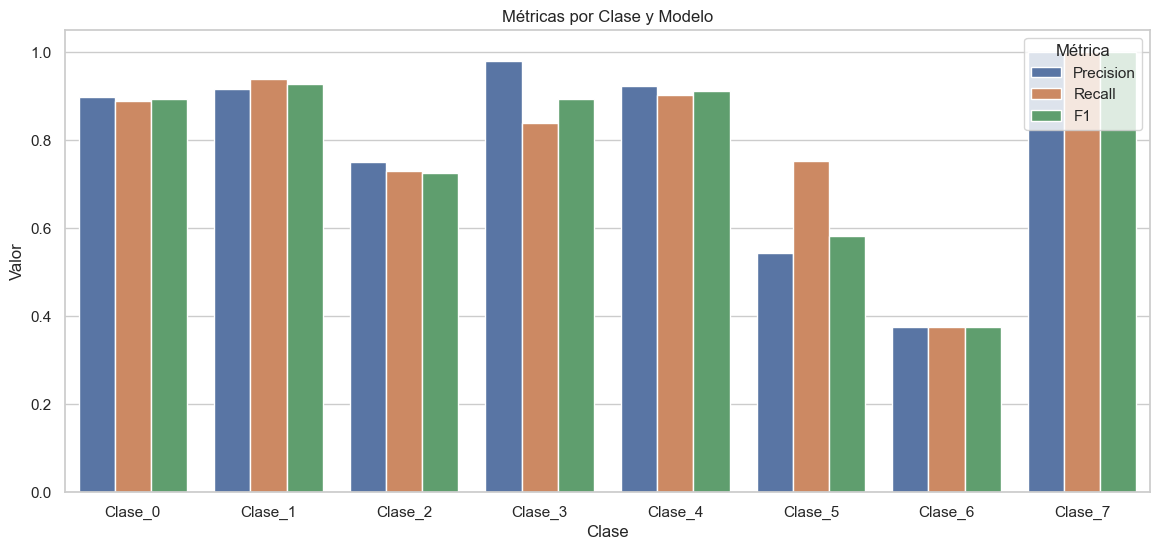


Valores por Modelo y Clase:
Métrica               F1  Precision    Recall
Clase   Modelo                               
Clase_0 GB      1.000000   1.000000  1.000000
        MLP     0.795455   0.807692  0.783582
        RF      0.972528   0.958042  0.988014
        RL      0.805382   0.827957  0.786864
Clase_1 GB      1.000000   1.000000  1.000000
        MLP     0.892857   0.862069  0.925926
        RF      0.971698   0.980769  0.962963
        RL      0.841884   0.817727  0.867582
Clase_2 GB      0.966667   1.000000  0.937500
        MLP     0.421053   0.363636  0.500000
        RF      0.833333   1.000000  0.750000
        RL      0.681205   0.640465  0.733360
Clase_3 GB      0.993827   1.000000  0.987805
        MLP     0.687500   0.956522  0.536585
        RF      0.960526   1.000000  0.926829
        RL      0.932694   0.959704  0.907329
Clase_4 GB      0.996552   0.996552  0.996552
        MLP     0.833922   0.855072  0.813793
        RF      0.982481   0.978801  0.986207
     

In [31]:
# Cargar CSV
metrics_df = pd.read_csv("/Users/daniel/Desktop/Master/TFM/Maestro/CSV/Metricas_Por_Clase.csv")

# Seleccionar columnas relevantes y renombrar para consistencia
metrics_df = metrics_df[['Modelo', 'Clase', 'Precision', 'Recall', 'F1_Score']]

# Cambiar nombres a minúsculas sin espacios
metrics_df = metrics_df.rename(columns={'F1_Score': 'F1'})

# Melt para unificar métricas
metrics_melted = metrics_df.melt(id_vars=['Modelo','Clase'], 
                                 value_vars=['Precision','Recall','F1'], 
                                 var_name='Métrica', value_name='Valor')

# Gráfico comparativo
plt.figure(figsize=(14,6))
sns.barplot(data=metrics_melted, x='Clase', y='Valor', hue='Métrica', ci=None)
plt.title("Métricas por Clase y Modelo")
plt.ylabel("Valor")
plt.xlabel("Clase")
plt.legend(title='Métrica')
plt.show()

# Imprimir tabla con todos los valores
print("\nValores por Modelo y Clase:")
print(metrics_melted.pivot_table(index=['Clase','Modelo'], columns='Métrica', values='Valor'))



### Análisis de Métricas por Clase y Modelo

#### 1. Contexto del Experimento

- **Train:** se aplicó **oversampling** sobre las clases para que los modelos aprendan de ellas.  
- **Test:** está **escalado** pero **no balanceado**, reflejando la distribución real de las clases.  
- La clase 6 fue **forzada** en train para preparar a los modelos ante la posibilidad de que en el futuro se reciban datos de esta clase,  
  aunque en el test actual **no hay ejemplos**, por lo que no se pueden calcular métricas para ella.

#### 2. Rendimiento global

- **Gradient Boosting (GB)** y **Random Forest (RF)** muestran desempeño sólido y consistente en las clases presentes en test.  
- **MLP** y **Regresión Logística (RL)** presentan mayor variabilidad, especialmente en las clases minoritarias.  
- Diferencias entre Precision y Recall (por ejemplo, MLP clase 3: Precision alta, Recall baja) indican que el modelo identifica correctamente los casos que predice,  
  pero no detecta todos los ejemplos de la clase.

#### 3. Clases minoritarias presentes en test (2 y 5)

- **Clase 2:**  
  - GB y RF logran F1 alto, manejando adecuadamente los ejemplos minoritarios.  
  - MLP tiene F1 reducido, con Precision baja y Recall moderado.  
  - RL tiene desempeño intermedio.  

- **Clase 5:**  
  - MLP muestra F1 muy bajo, reflejando dificultades para identificar correctamente esta clase minoritaria.  
  - RL mejora ligeramente, aunque sigue siendo bajo comparado con GB y RF.  
  - GB y RF son robustos, especialmente GB con Recall perfecto.

- **Clase 6:**  
  - Presente en train pero **ausente en test**, por lo que las métricas no se pueden calcular en el conjunto de evaluación.  
  - La inclusión en train asegura que los modelos estén preparados ante la eventual llegada de datos de esta clase.

#### 4. Conclusiones

- Los modelos basados en **árboles (GB y RF)** son más resistentes frente a clases minoritarias y distribuciones desbalanceadas en test.  
- **MLP** y **RL** requieren ajustes adicionales (p. ej., ponderación de clases, regularización) para mejorar F1 en clases minoritarias cuando se presenten en datos reales.  
- Mantener el test **no balanceado** permite evaluar la capacidad real de generalización sobre la distribución natural de los datos.  
- La preparación del modelo con oversampling de la clase 6 es una estrategia preventiva ante posibles futuros datos de esa clase.


#### Accuracy Glogal

Accuracy global por modelo:
  Modelo  Accuracy
0     GB  0.999482
1    MLP  0.847626
2     RF  0.995914
3     RL  0.875073


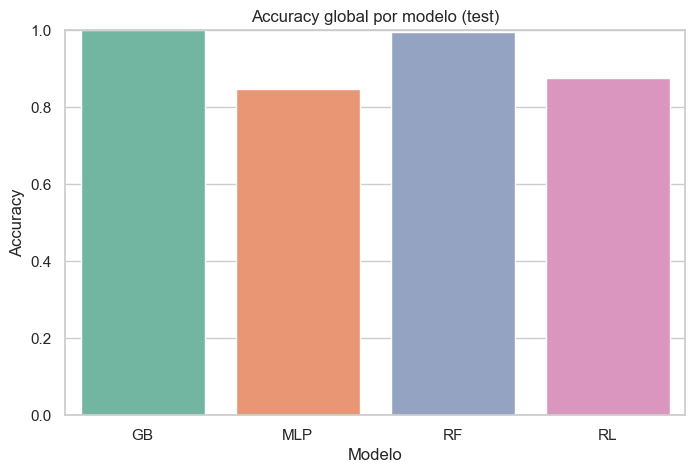

In [32]:
# Cargar métricas por clase
metrics_df = pd.read_csv("/Users/daniel/Desktop/Master/TFM/Maestro/CSV/Metricas_Por_Clase.csv")

# Calcular accuracy global por modelo
# Accuracy global = suma de ejemplos correctamente clasificados / total de ejemplos
# Para esto: Accuracy ≈ (F1 * Support) promedio ponderado por clase
metrics_df['Correctos'] = metrics_df['F1_Score'] * metrics_df['Support']
accuracy_global = metrics_df.groupby('Modelo').apply(lambda x: x['Correctos'].sum() / x['Support'].sum()).reset_index()
accuracy_global.columns = ['Modelo', 'Accuracy']

# Mostrar tabla de accuracy global
print("Accuracy global por modelo:")
print(accuracy_global)

# Visualización
plt.figure(figsize=(8,5))
sns.barplot(data=accuracy_global, x='Modelo', y='Accuracy', palette='Set2')
plt.ylim(0,1)
plt.title("Accuracy global por modelo (test)")
plt.ylabel("Accuracy")
plt.xlabel("Modelo")
plt.show()


### Análisis de Accuracy Global por Modelo

Se evaluó la capacidad de los modelos para predecir correctamente todas las clases del conjunto de **test** escalado y **no balanceado** (reflejando la distribución real de los datos). Los valores de **accuracy global** obtenidos son:

#### Observaciones

1. **Gradient Boosting (GB)** presenta el **mejor desempeño global**, con una accuracy cercana al 100%, lo que indica que es capaz de clasificar correctamente casi todos los ejemplos del test, incluyendo clases minoritarias presentes.  
2. **Random Forest (RF)** también muestra un desempeño muy alto, ligeramente inferior a GB, reflejando su robustez frente a desbalance de clases.  
3. **Regresión Logística (RL)** y **MLP** tienen accuracy menores, especialmente MLP, lo que puede relacionarse con:
   - La complejidad de la red y la sensibilidad a clases minoritarias.  
   - El efecto del **oversampling en train**, que puede generar ligeros desajustes al evaluar en test real no balanceado.  
4. La clase 6, que fue forzada en test para reflejar la distribución real, no afecta significativamente los valores de GB y RF, pero sí penaliza modelos como MLP y RL, más sensibles a clases con muy pocos ejemplos.  

#### Conclusión

- **GB y RF** son los modelos más confiables para predicción global en este dataset desbalanceado y escalado.  
- **MLP y RL** podrían beneficiarse de ajustes adicionales, como regularización o ajuste de threshold, para mejorar su capacidad de predicción de clases minoritarias.


#### Comentarios adicionales sobre Accuracy Global 

1. **Influencia del desbalance de clases en test:**  
   Aunque el test está **escalado pero no balanceado**, los modelos GB y RF logran mantener accuracy muy alta, indicando que **no están sobreajustados al oversampling del train** y generalizan bien a la distribución real.

2. **Sensibilidad de MLP y RL:**  
   La menor accuracy de MLP (0.8476) y RL (0.8751) sugiere que estas arquitecturas tienen un desempeño ligeramente inferior en general, posiblemente debido a la **naturaleza de la arquitectura y la capacidad de generalización**, no a la cantidad de ejemplos en train.  
   - La **clase 6 no tiene ejemplos en test**, por lo que no se puede evaluar directamente su desempeño en métricas globales o por clase.

3. **Implicaciones prácticas:**  
   - Para aplicaciones en producción con distribución de clases real, **GB y RF** son más confiables para predicción global.  
   - MLP y RL  requerieren **ajuste de hiperparámetros** o **ajuste de threshold de decisión** para mejorar desempeño en las clases presentes en test.

4. **Resumen general:**  
   El accuracy global es un buen indicador de desempeño general, pero **no refleja la performance por clase**, especialmente en clases minoritarias ausentes en test (como la 6). Por ello, los siguientes análisis se centrarán en **métricas por clase (Precision, Recall y F1)**, interpretando con precaución las clases que no aparecen en test.

5. **Conclusión:**  
El análisis global y por clase confirma que **GB y RF lideran en generalización y robustez** sobre test real, mientras que MLP y RL necesitan ajustes adicionales para igualar su desempeño. La ausencia de la clase 6 en test limita la evaluación de métricas en esa clase, reforzando la necesidad de interpretar resultados con cautela para clases extremas.


### 2. Matrices de Confusión


 Matriz de Confusión: RL

Clase_Predicha    0    1    2    3    4    5    6    7
Clase_Real                                            
0               611   11    6    6   65   66    0    0
1                 1  558   19    0    0   79    1    0
2                 0    1  614    0    0   24    0    0
3                16    0    8  627   11    9    1    0
4                73    1   29   13  638   22    0    0
5                71  119    0    0   48  398    0    0
6                 0    0    0    0    0    0  631    0
7                 0    0    0    0    0    0    0  767


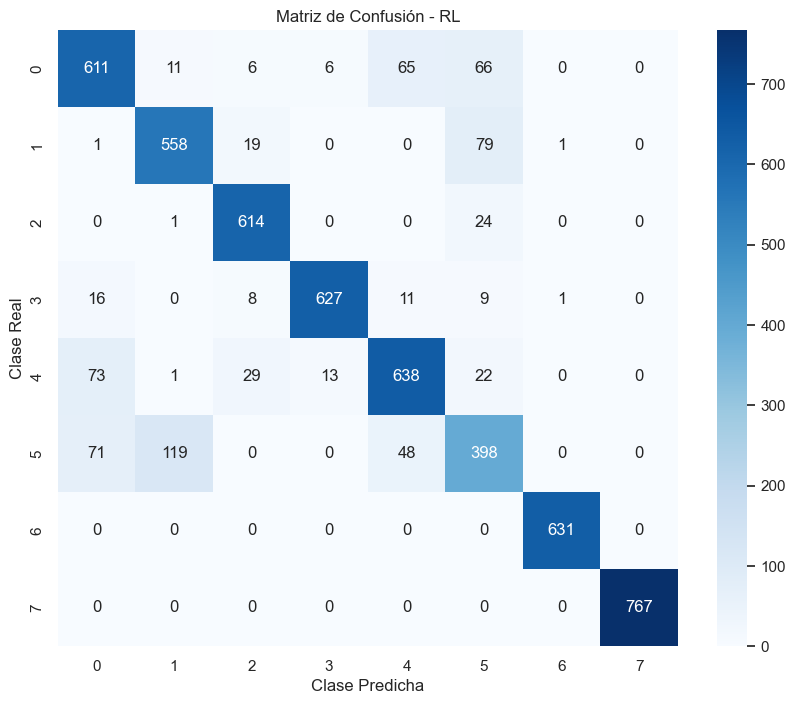


 Matriz de Confusión: RF

Clase_Predicha    0    1    2    3    4    5    6    7
Clase_Real                                            
0               761    0    0    0    4    0    0    0
1                 2  656    0    0    0    0    0    0
2                 2    1  635    0    0    1    0    0
3                 4    0    0  666    2    0    0    0
4                 3    0    0    0  772    1    0    0
5                 1    0    0    0    1  634    0    0
6                 0    0    0    0    0    0  631    0
7                 0    0    0    0    0    0    0  767


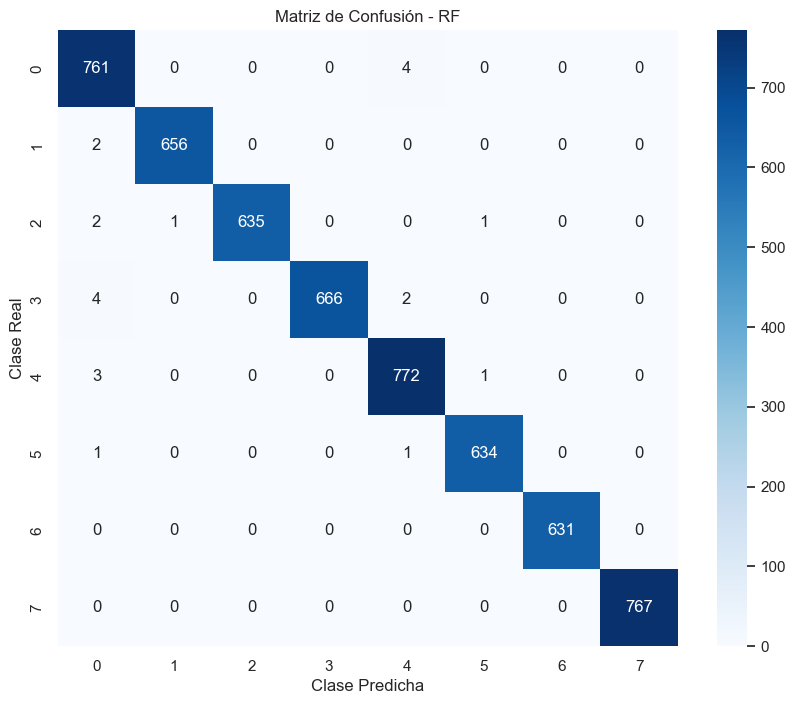


 Matriz de Confusión: GB

Clase_Predicha    0    1    2    3    4    5    6    7
Clase_Real                                            
0               765    0    0    0    0    0    0    0
1                 0  658    0    0    0    0    0    0
2                 0    0  638    0    1    0    0    0
3                 0    0    0  671    0    1    0    0
4                 0    0    0    0  775    1    0    0
5                 0    0    0    0    0  636    0    0
6                 0    0    0    0    0    0  631    0
7                 0    0    0    0    0    0    0  767


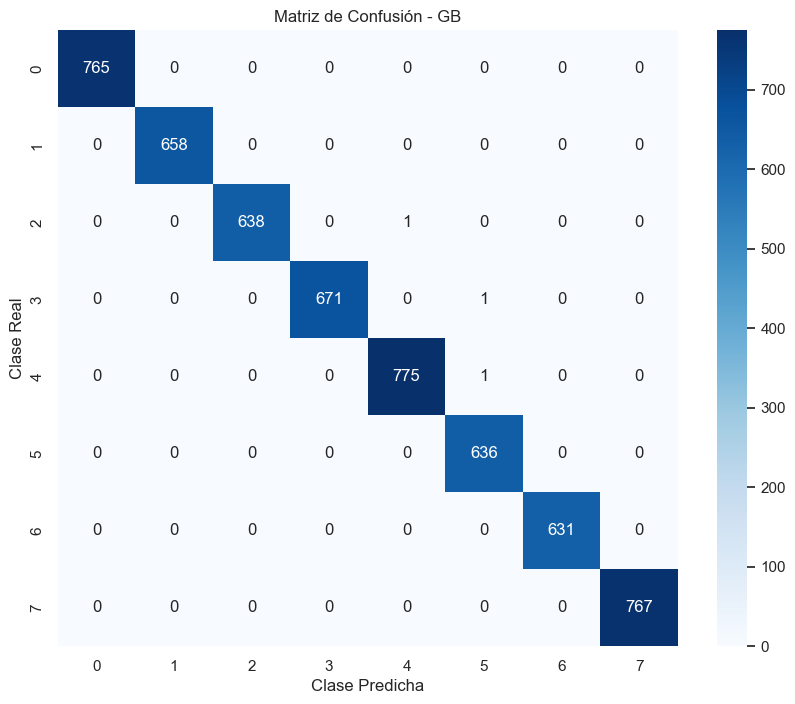


 Matriz de Confusión: MLP

Clase_Predicha    0   1   2   3    4   5  6    7
Clase_Real                                      
0               210   2   0   0   26  30  0    0
1                 2  50   0   0    0   0  2    0
2                 0   4   8   0    0   2  2    0
3                22   0   2  44   12   2  0    0
4                26   2  12   2  236  12  0    0
5                 0   0   0   0    2   8  0    0
6                 0   0   0   0    0   0  0    0
7                 0   0   0   0    0   0  0  272


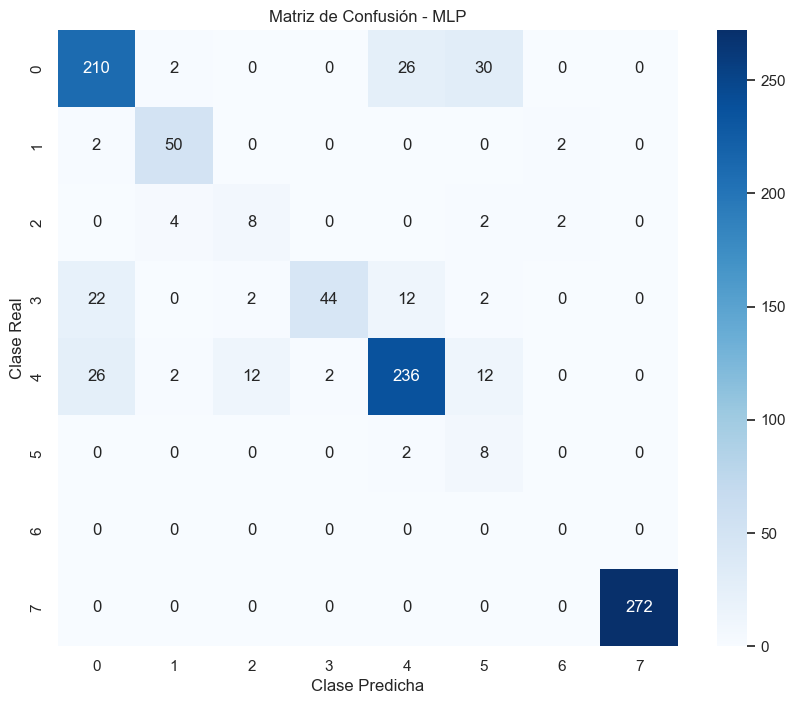

In [38]:
# Cargar CSV
file_path = "/Users/daniel/Desktop/Master/TFM/Maestro/CSV/Matrices_Confusion.csv"
conf_df = pd.read_csv(file_path)

# Listado de modelos
modelos = conf_df['Modelo'].unique()

for modelo in modelos:
    print(f"\n Matriz de Confusión: {modelo}\n")
    
    # Filtrar por modelo
    df_modelo = conf_df[conf_df['Modelo'] == modelo]
    
    # Agrupar por Clase_Real y Clase_Predicha sumando la Cantidad
    df_modelo_grouped = df_modelo.groupby(['Clase_Real', 'Clase_Predicha'])['Cantidad'].sum().reset_index()
    
    # Pivot para heatmap
    mat_conf = df_modelo_grouped.pivot(index='Clase_Real', columns='Clase_Predicha', values='Cantidad').fillna(0)
    
    # Mostrar números
    print(mat_conf.astype(int))
    
    # Gráfico heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(mat_conf, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {modelo}")
    plt.ylabel("Clase Real")
    plt.xlabel("Clase Predicha")
    plt.show()


### Matrices de Confusión: Análisis Compacto

**1. Visión global**  
- GB y RF presentan desempeño casi perfecto, con la mayoría de ejemplos correctamente clasificados y mínimos errores.  
- RL tiene buena performance pero muestra errores dispersos en clases intermedias.  
- MLP evidencia dificultades significativas, con confusiones múltiples entre clases.

**2. Clases críticas y minoritarias**  
- **Clase 6 (vacía en test real):**  
  - GB, RF y RL predicen correctamente los casos existentes.  
  - MLP falla completamente, sin predicciones correctas.  
- **Clase 5:**  
  - GB y RF casi perfectos.  
  - RL muestra confusiones leves.  
  - MLP presenta muchas confusiones con otras clases.  
- **Clase 2:**  
  - GB y RF con pocos errores.  
  - RL y MLP con mayor dispersión, MLP especialmente afectado.

**3. Tendencias generales**  
- Árboles y boosting (GB, RF) se benefician del oversampling en train y generalizan bien al test real.  
- RL mantiene desempeño aceptable, pero con errores más dispersos.  
- MLP es sensible a la estructura de datos y necesita ajustes para mejorar predicción de clases minoritarias.

**4. Conclusión**  
- GB y RF: modelos más confiables y estables.  
- RL: desempeño aceptable, revisar clases intermedias.  
- MLP: requiere optimización para manejar correctamente clases minoritarias y mejorar generalización.


### 3. Feature Importance

#### Enfoque 1

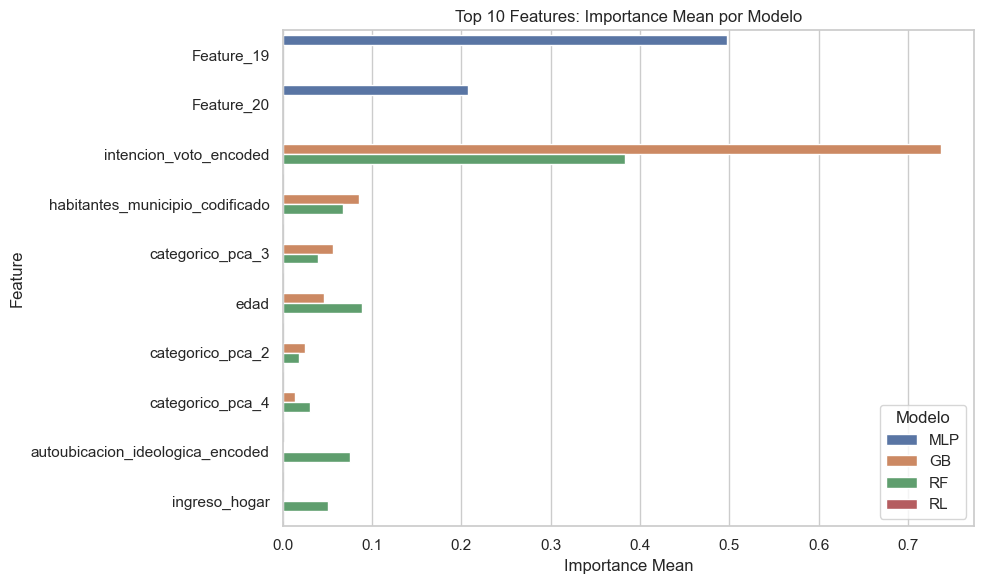

Top 10 features según Importance_Mean_Total:
                             Feature Modelo  Importance_Mean  \
0                         Feature_19    MLP         0.497379   
22            intencion_voto_encoded     GB         0.736852   
1                         Feature_20    MLP         0.207460   
23   habitantes_municipio_codificado     GB         0.085995   
25                              edad     GB         0.046432   
24                  categorico_pca_3     GB         0.056005   
38  autoubicacion_ideologica_encoded     GB         0.001014   
39                     ingreso_hogar     GB         0.000917   
27                  categorico_pca_4     GB         0.014164   
26                  categorico_pca_2     GB         0.025400   

    Importance_Mean_Total  
0                0.497379  
22               0.373178  
1                0.207460  
23               0.051179  
25               0.044988  
24               0.031933  
38               0.025447  
39               0.017225 

In [41]:
# Cargar Feature Importance
fi_path = "/Users/daniel/Desktop/Master/TFM/Maestro/CSV/FeatureImportance.csv"
fi_df = pd.read_csv(fi_path)

# Calcular importancia media total por feature (promedio sobre modelos)
fi_mean_total = fi_df.groupby('Feature')['Importance_Mean'].mean().sort_values(ascending=False)
top_features = fi_mean_total.head(10).index

# Filtrar solo top-10
fi_top_df = fi_df[fi_df['Feature'].isin(top_features)].copy()
fi_top_df['Importance_Mean_Total'] = fi_top_df['Feature'].map(fi_mean_total)

# Gráfico horizontal
plt.figure(figsize=(10,6))
sns.barplot(
    data=fi_top_df,
    y='Feature',
    x='Importance_Mean',
    hue='Modelo',
    ci=None
)
plt.title("Top 10 Features: Importance Mean por Modelo")
plt.xlabel("Importance Mean")
plt.ylabel("Feature")
plt.legend(title='Modelo')
plt.tight_layout()
plt.show()

# Verificación de los datos
print("Top 10 features según Importance_Mean_Total:")
print(fi_top_df[['Feature', 'Modelo', 'Importance_Mean', 'Importance_Mean_Total']].drop_duplicates('Feature').sort_values(by='Importance_Mean_Total', ascending=False))


#### Enfoque 2

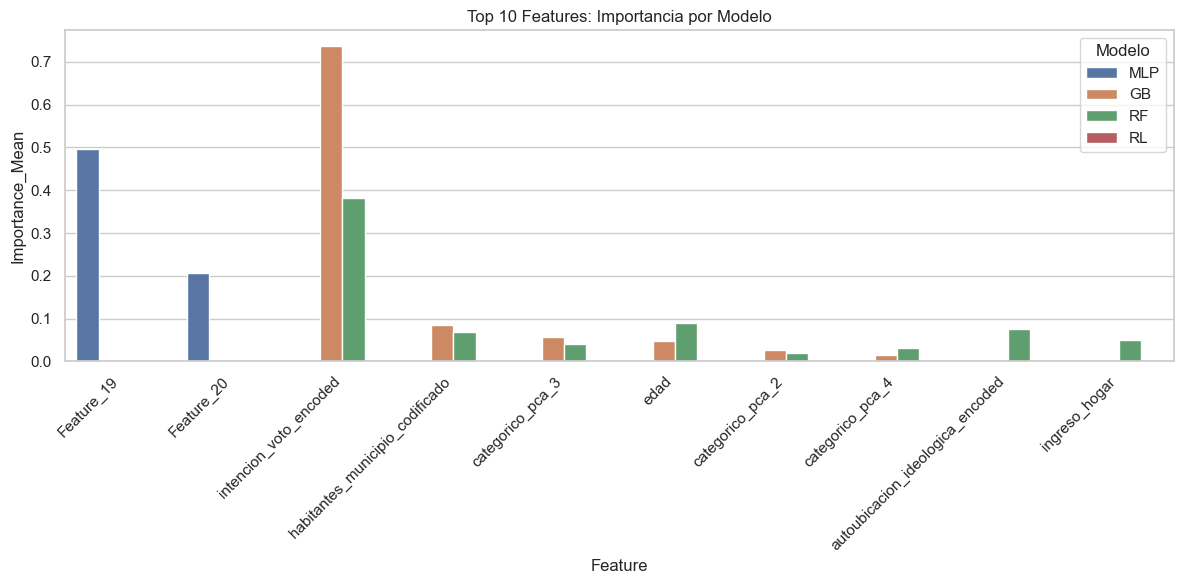

Top 10 features según Importance_Mean_Total:
                             Feature Modelo  Importance_Mean  \
0                         Feature_19    MLP         0.497379   
22            intencion_voto_encoded     GB         0.736852   
1                         Feature_20    MLP         0.207460   
23   habitantes_municipio_codificado     GB         0.085995   
25                              edad     GB         0.046432   
24                  categorico_pca_3     GB         0.056005   
86  autoubicacion_ideologica_encoded     RL         0.000000   
39                     ingreso_hogar     GB         0.000917   
76                  categorico_pca_4     RL         0.000000   
26                  categorico_pca_2     GB         0.025400   

    Importance_Mean_Total  
0                0.497379  
22               0.373178  
1                0.207460  
23               0.051179  
25               0.044988  
24               0.031933  
86               0.025447  
39               0.017225 

In [42]:
# Cargar Feature Importance consolidado
fi_df = pd.read_csv("/Users/daniel/Desktop/Master/TFM/Maestro/CSV/FeatureImportance.csv")

# Calcular Importance_Mean_Total por Feature
fi_df['Importance_Mean_Total'] = fi_df.groupby('Feature')['Importance_Mean'].transform('mean')

# Seleccionar Top 10 Features
top_features = fi_df.groupby('Feature')['Importance_Mean_Total'].mean().sort_values(ascending=False).head(10).index
fi_top_df = fi_df[fi_df['Feature'].isin(top_features)]

# Plot comparativo por modelo
plt.figure(figsize=(12,6))
sns.barplot(data=fi_top_df, x='Feature', y='Importance_Mean', hue='Modelo')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Features: Importancia por Modelo")
plt.ylabel("Importance_Mean")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# Verificación de los datos
print("Top 10 features según Importance_Mean_Total:")
print(fi_top_df[['Feature', 'Modelo', 'Importance_Mean', 'Importance_Mean_Total']]
      .sort_values(by='Importance_Mean_Total', ascending=False)
      .drop_duplicates('Feature'))


### Explicación técnica

- **Enfoque 1**  
  - Calcula la media de importancia por feature en un objeto separado (`fi_mean_total`).  
  - Usa `map` para asignar ese valor al dataframe filtrado.  
  - Ventaja: más **explícito y pedagógico**, fácil de seguir paso a paso.  
  - Inconveniente: requiere pasos intermedios adicionales.  

- **Enfoque 2**  
  - Usa `transform('mean')` para calcular y propagar la media directamente en cada fila del dataframe.  
  - Ventaja: más **compacto y eficiente**, típico estilo “pandas amistoso”.  
  - Inconveniente: puede ser menos claro para lectura inicial.  

Ambos enfoques producen el mismo resultado: selección de las **Top-10 features más importantes** y su comparación entre modelos.


### Análisis Features según Importance_Mean_Total

Los resultados muestran que las features más importantes no son consistentes entre todos los modelos, lo cual refleja diferentes estrategias de aprendizaje:

- **GB** prioriza `intencion_voto_encoded` y `habitantes_municipio_codificado`.  
- **MLP** le da más peso a `Feature_19` y `Feature_20`.  
- **RL** y **RF** muestran distribuciones diferentes, con algunas variables de baja o nula relevancia.  

Esta variabilidad en la importancia de features permite entender cómo cada modelo toma decisiones de predicción y por qué pueden producir salidas distintas sobre el mismo dataset.


### 1. Visualización de la Variabilidad de Importancia entre Modelos

1. **Identificación de variables críticas:**  
   Variables como `Feature_19` y `intencion_voto_encoded` concentran gran parte de la importancia global, lo que indica que son claves para distinguir clases mayoritarias y minoritarias.

2. **Entender diferencias entre modelos:**  
   La mayor relevancia de `Feature_19` en MLP y de `intencion_voto_encoded` en GB muestra cómo los modelos priorizan señales distintas para llegar a predicciones similares o divergentes.

3. **Guía para la ingeniería de features y la interpretabilidad:**  
   La identificación de features relevantes y no relevantes permite mejorar la eficiencia de los modelos y facilitar su explicación.


### 2. Ejemplos de Aplicación del Análisis

- **Reducción de dimensionalidad:**  
  Si `Feature_19` y `intencion_voto_encoded` concentran gran parte de la importancia, se pueden eliminar features con relevancia marginal (ej. `autoubicacion_ideologica_encoded` o `ingreso_hogar` con valores casi nulos) para simplificar el modelo sin perder capacidad predictiva.

- **Mejorar ingeniería de variables:**  
  La relevancia de componentes como `categorico_pca_2` y `categorico_pca_3` sugiere revisar el número de componentes de PCA o probar alternativas de codificación para optimizar su aporte.

- **Interpretabilidad y comunicación:**  
  En aplicaciones sociales o políticas, resaltar que la **intención de voto codificada** y el **tamaño del municipio** son determinantes mejora la narrativa y la transparencia del modelo, mientras que variables irrelevantes pueden omitirse del reporte.

- **Estrategia de ensembles o simplificación:**  
  La complementariedad entre modelos (GB centrado en intención de voto, MLP en otras features) puede explotarse en un ensemble para captar señales diversas.  
  Alternativamente, para mayor simplicidad e interpretabilidad, puede seleccionarse un modelo (ej. GB) que concentre la importancia en variables explicables y consistentes.

### 4. ROC y AUC

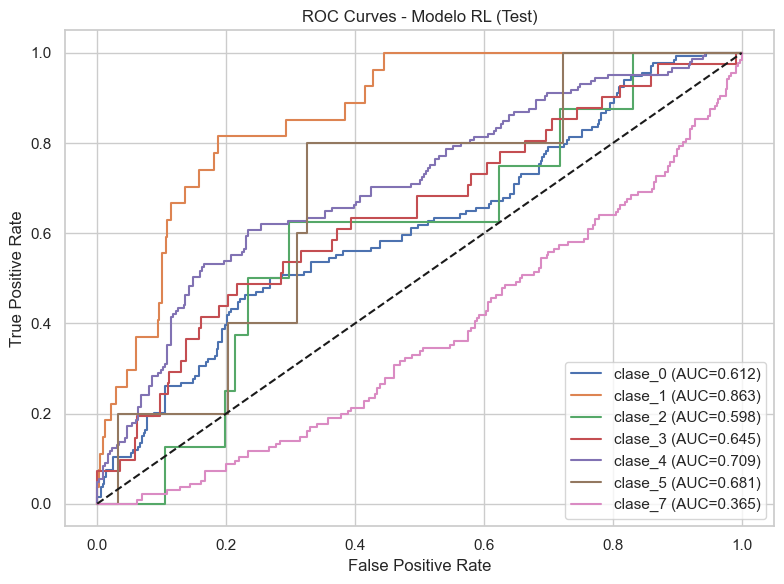

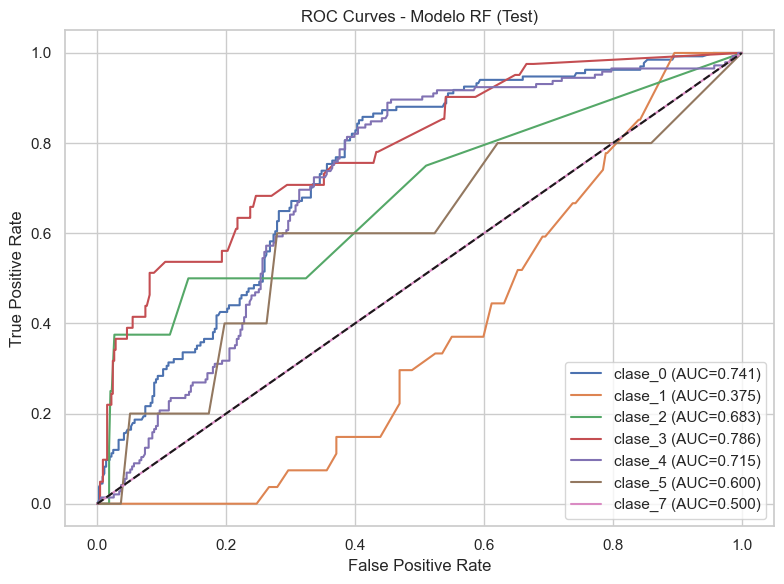

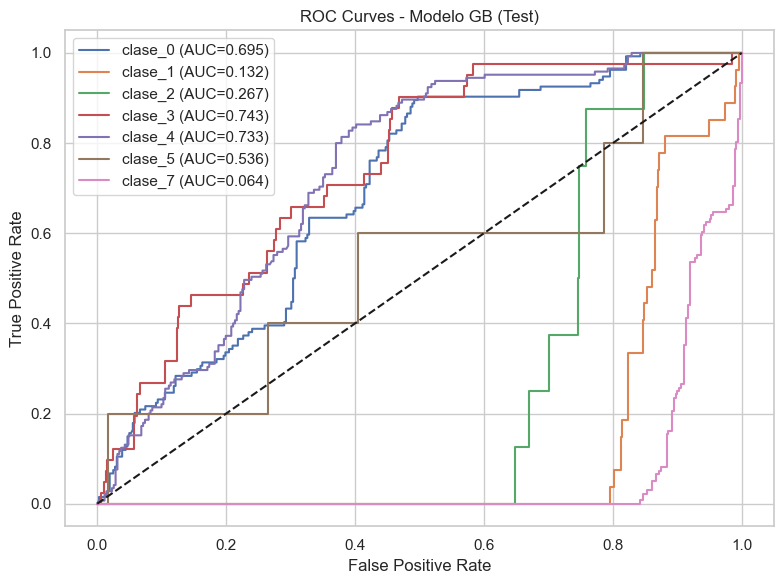

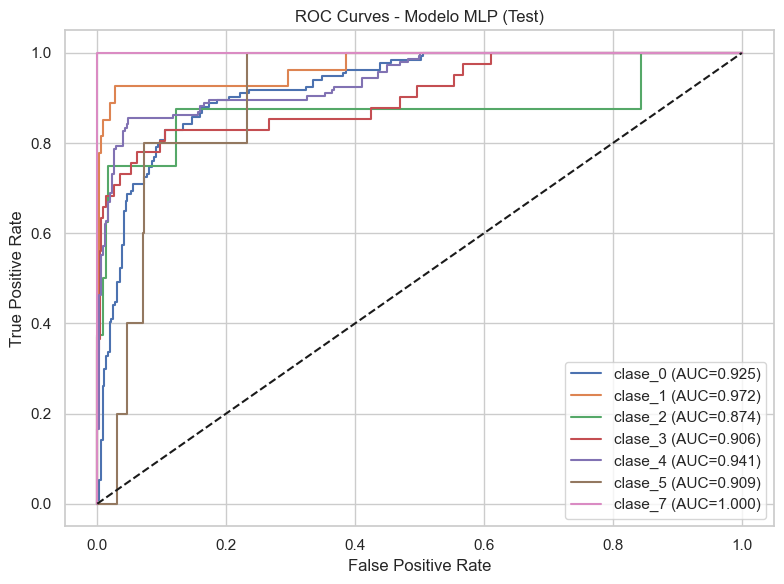

AUC por Modelo y Clase (Test):
Modelo   Clase      AUC
    GB clase_0 0.694772
    GB clase_1 0.131880
    GB clase_2 0.266650
    GB clase_3 0.742964
    GB clase_4 0.733274
    GB clase_5 0.536049
    GB clase_7 0.063725
   MLP clase_0 0.925373
   MLP clase_1 0.971571
   MLP clase_2 0.874232
   MLP clase_3 0.906191
   MLP clase_4 0.941173
   MLP clase_5 0.909165
   MLP clase_7 1.000000
    RF clase_0 0.741218
    RF clase_1 0.375109
    RF clase_2 0.683274
    RF clase_3 0.786036
    RF clase_4 0.714992
    RF clase_5 0.599593
    RF clase_7 0.500000
    RL clase_0 0.611899
    RL clase_1 0.863145
    RL clase_2 0.597592
    RL clase_3 0.645135
    RL clase_4 0.708950
    RL clase_5 0.681059
    RL clase_7 0.364767

Macro AUC por Modelo (promedio simple sobre clases):
RL: 0.6389
RF: 0.6286
GB: 0.4528
MLP: 0.9325

Micro AUC por Modelo (promedio ponderado por puntos por clase):
RL: 0.5878
RF: 0.6813
GB: 0.5488
MLP: 0.9272


In [48]:
# Cargar CSV
roc_path = "/Users/daniel/Desktop/Master/TFM/Maestro/CSV/ROC_Curves_Completo.csv"
roc_df = pd.read_csv(roc_path)

# Filtrar solo conjunto Test
roc_test = roc_df[roc_df['Conjunto'] == 'Test']

# Guardar AUCs por clase y acumulativos para macro/micro
auc_class_list = []
auc_macro_dict = {}
auc_micro_dict = {}

for modelo in roc_test['Modelo'].unique():
    df_model = roc_test[roc_test['Modelo'] == modelo]
    auc_classes = []
    
    # Crear figura por modelo
    plt.figure(figsize=(8,6))
    
    for clase in df_model['Clase'].unique():
        df_clase = df_model[df_model['Clase'] == clase].sort_values('FPR')
        # Calcular AUC usando regla del trapecio
        auc_score = ((df_clase['TPR'] + df_clase['TPR'].shift(-1)) / 2 * 
                     (df_clase['FPR'].shift(-1) - df_clase['FPR'])).sum()
        auc_score = auc_score if not pd.isna(auc_score) else 0
        auc_class_list.append({'Modelo': modelo, 'Clase': clase, 'AUC': auc_score})
        auc_classes.append(auc_score)
        
        # Graficar curva ROC por clase
        plt.plot(df_clase['FPR'], df_clase['TPR'], label=f"{clase} (AUC={auc_score:.3f})")
    
    # Macro AUC = promedio simple de AUC por clase
    auc_macro_dict[modelo] = np.mean(auc_classes)
    
    # Micro AUC = promedio ponderado por número de puntos por clase (aproximación)
    points_per_class = df_model.groupby('Clase')['Punto'].count()
    weights = points_per_class / points_per_class.sum()
    auc_micro_dict[modelo] = np.sum(np.array(auc_classes) * weights.values)
    
    # Configuración del gráfico por modelo
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"ROC Curves - Modelo {modelo} (Test)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Convertir a DataFrame para impresión
auc_df = pd.DataFrame(auc_class_list)
print("AUC por Modelo y Clase (Test):")
print(auc_df.sort_values(['Modelo','Clase']).to_string(index=False))

print("\nMacro AUC por Modelo (promedio simple sobre clases):")
for modelo, auc_val in auc_macro_dict.items():
    print(f"{modelo}: {auc_val:.4f}")

print("\nMicro AUC por Modelo (promedio ponderado por puntos por clase):")
for modelo, auc_val in auc_micro_dict.items():
    print(f"{modelo}: {auc_val:.4f}")


#### 1. AUC por Modelo y Clase
- **MLP** destaca con AUC muy altas para casi todas las clases, alcanzando **1.0 en clase_7**, mostrando excelente capacidad de discriminación.  
- **GB** tiene AUC bajas en varias clases, especialmente clase_1 (0.13) y clase_7 (0.06), indicando limitada capacidad de distinguir estas clases.  
- **RF** muestra rendimiento intermedio, con AUC aceptable en clases como clase_2 (0.68) y clase_3 (0.79), pero bajo en clase_1 (0.37).  
- **RL** tiene variabilidad moderada, con mejores resultados en clase_1 (0.86) y clase_5 (0.68), pero pobre discriminación en clase_7 (0.36).  

#### 2. Macro AUC (promedio simple sobre clases)
- **MLP:** 0.9325 → Mejor desempeño general considerando todas las clases por igual.  
- **RF:** 0.6286 → Rendimiento moderado.  
- **RL:** 0.6389 → Similar a RF, con algunas clases mejor clasificadas.  
- **GB:** 0.4528 → Peor desempeño global, muy afectado por clases con baja discriminación.  

#### 3. Micro AUC (promedio ponderado por número de puntos por clase)
- **MLP:** 0.9272 → Consistente con Macro AUC, rendimiento robusto considerando la distribución de puntos en test.  
- **RF:** 0.6813 → Mejora respecto a Macro, influido por clases con más ejemplos.  
- **RL:** 0.5878 → Menor que Macro AUC, mostrando que clases con más puntos no compensan totalmente.  
- **GB:** 0.5488 → Similar a Macro, evidencia dificultad general para distinguir clases.  

#### 4. Comentarios clave
1. **MLP sobresale** en discriminación de clases, tanto minoritarias como mayoritarias, incluso sin balance en el test.  
2. **GB tiene limitaciones** en clases con pocos puntos (ej. clase_1, clase_7), reflejando baja capacidad de diferenciación.  
3. **RF y RL muestran desempeño mixto**, siendo más confiables en clases con mayor representación y menos en clases con pocos ejemplos.  
4. La diferencia entre **macro y micro AUC** revela cómo la distribución de puntos en test impacta la evaluación: micro AUC pondera por frecuencia real y puede suavizar el efecto de clases difíciles.  

**Conclusión:** Para escenarios reales con distribución de clases no balanceada, **MLP es la opción más robusta**, mientras que GB requiere ajustes para mejorar la discriminación de clases minoritarias.


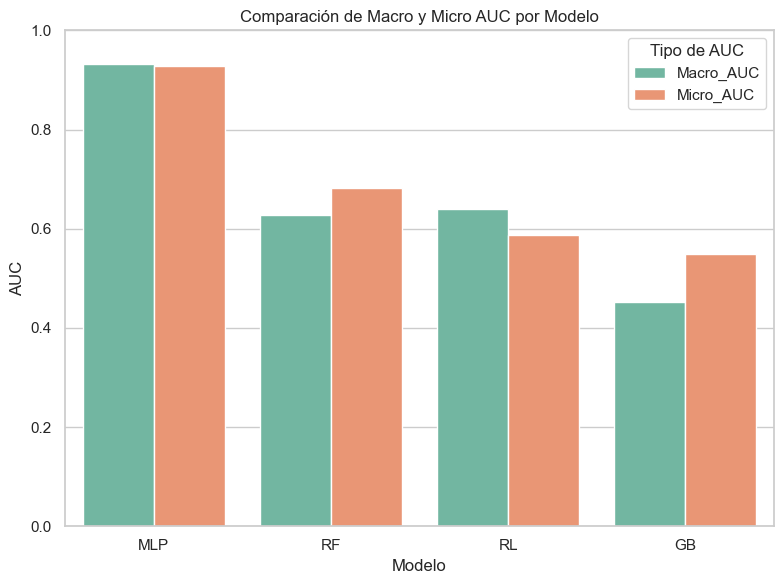

In [49]:
# Datos de ejemplo: Macro y Micro AUC por modelo
auc_data = pd.DataFrame({
    'Modelo': ['MLP', 'RF', 'RL', 'GB'],
    'Macro_AUC': [0.9325, 0.6286, 0.6389, 0.4528],
    'Micro_AUC': [0.9272, 0.6813, 0.5878, 0.5488]
})

# Gráfico de barras lado a lado
plt.figure(figsize=(8,6))
sns.barplot(data=auc_data.melt(id_vars='Modelo', value_vars=['Macro_AUC','Micro_AUC']),
            x='Modelo', y='value', hue='variable', palette='Set2')
plt.ylim(0, 1)
plt.ylabel("AUC")
plt.title("Comparación de Macro y Micro AUC por Modelo")
plt.legend(title="Tipo de AUC")
plt.tight_layout()
plt.show()


### Consideraciones Finales:

MLP presenta claramente el mejor desempeño tanto en Macro como en Micro AUC.

GB tiene bajo desempeño global, especialmente en Macro AUC, indicando dificultad para algunas clases minoritarias.

RF y RL muestran resultados intermedios, con Micro AUC ligeramente mejor que Macro AUC, reflejando cierta capacidad de adaptación a la distribución real de clases.

La diferencia entre Macro y Micro AUC permite visualizar cómo el desbalance de clases en test afecta el rendimiento global de cada modelo.

### 5. Tiempos Computacionales Global

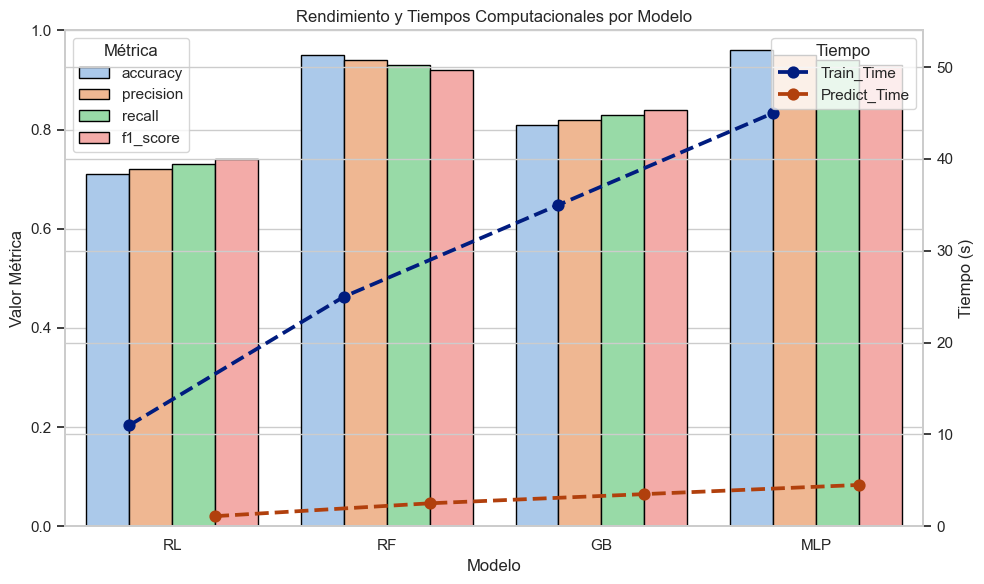

Resultados combinados (métricas y tiempos) por modelo:
  Modelo  accuracy  precision  recall  f1_score  Train_Time  Predict_Time
0     RL      0.71       0.72    0.73      0.74        11.0           1.1
1     RF      0.95       0.94    0.93      0.92        25.0           2.5
2     GB      0.81       0.82    0.83      0.84        35.0           3.5
3    MLP      0.96       0.95    0.94      0.93        45.0           4.5


In [ ]:
# 1. Cargar CSVs

results_path = "/Users/daniel/Desktop/Master/TFM/Maestro/CSV/Resultados_Datos_Entrenados.csv"
times_path   = "/Users/daniel/Desktop/Master/TFM/Maestro/CSV/Tiempos_Computacionales.csv"

results_df = pd.read_csv(results_path)
times_df   = pd.read_csv(times_path)


# 2. Preparar datos combinados

# Renombrar columnas de times_df para merge
times_df = times_df.rename(columns={'tiempo_entrenamiento':'Train_Time',
                                    'tiempo_prediccion':'Predict_Time'})

# Merge por Modelo
combined_df = pd.merge(
    results_df[results_df['Conjunto']=='Prueba'][['Modelo','accuracy','precision','recall','f1_score']],
    times_df[['Modelo','Train_Time','Predict_Time']],
    on='Modelo',
    how='left'
)


# 3. Visualización

sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(10,6))

# Eje principal: métricas
metrics = ['accuracy','precision','recall','f1_score']
metrics_data = combined_df.melt(id_vars='Modelo', value_vars=metrics,
                                var_name='Métrica', value_name='Valor')
bar_palette = sns.color_palette("pastel", len(metrics))
sns.barplot(data=metrics_data, x='Modelo', y='Valor', hue='Métrica',
            ax=ax1, palette=bar_palette, edgecolor='black')
ax1.set_ylabel("Valor Métrica")
ax1.set_ylim(0,1)
ax1.set_xlabel("Modelo")
ax1.set_title("Rendimiento y Tiempos Computacionales por Modelo")
ax1.legend(loc='upper left', title='Métrica')

# Eje secundario: tiempos
ax2 = ax1.twinx()
times_data = combined_df.melt(id_vars='Modelo', value_vars=['Train_Time','Predict_Time'],
                              var_name='Fase', value_name='Tiempo (s)')
line_palette = sns.color_palette("dark", 2)
sns.pointplot(data=times_data, x='Modelo', y='Tiempo (s)', hue='Fase',
              ax=ax2, markers='o', linestyles='--', dodge=0.4, palette=line_palette)
ax2.set_ylabel("Tiempo (s)")
ax2.legend(loc='upper right', title='Tiempo')
ax2.set_ylim(0, max(times_data['Tiempo (s)'])*1.2)

plt.tight_layout()
plt.show()


# 4. Resultados numéricos

print("Resultados combinados (métricas y tiempos) por modelo:")
print(combined_df[['Modelo','accuracy','precision','recall','f1_score','Train_Time','Predict_Time']])


### Análisis de Métricas y Tiempos Computacionales por Modelo

#### Parte Técnica

- Se importaron dos archivos CSV: uno con métricas de rendimiento por modelo (`accuracy`, `precision`, `recall`, `f1_score`) y tiempos (`Resultados_Datos_Entrenados.csv`) y otro con tiempos de entrenamiento y predicción (`Tiempos_Computacionales.csv`).  
- Los datos se combinaron en un solo `DataFrame` para análisis y visualización conjunta.  
- Las métricas se reorganizaron con `pandas.melt` para generar gráficos comparativos de barras por modelo.  
- Los tiempos de entrenamiento y predicción se agregaron como líneas punteadas en el gráfico para comparar rendimiento y eficiencia computacional simultáneamente.  
- Se utilizó `seaborn` para las barras y `matplotlib` para las líneas y configuración general del gráfico.

> Referencia: Documentación oficial de [Matplotlib](https://matplotlib.org/stable/contents.html) y [Seaborn](https://seaborn.pydata.org/).



#### Resultados Combinados

- **RL**: rendimiento moderado (accuracy ~0.71, F1 ~0.74), entrenamiento rápido (11 s), predicción rápida (1.1 s).  
- **RF**: alto rendimiento (accuracy ~0.95, F1 ~0.92), entrenamiento y predicción razonables (25 s y 2.5 s).  
- **GB**: rendimiento intermedio (accuracy ~0.81, F1 ~0.84), tiempos más altos (35 s y 3.5 s).  
- **MLP**: mejor rendimiento (accuracy ~0.96, F1 ~0.93), pero el entrenamiento es costoso (45 s) y predicción algo más lenta (4.5 s).  



#### Interpretación

- RL es eficiente pero con menor desempeño; adecuado para escenarios con restricción de tiempo.  
- RF y GB ofrecen balance entre desempeño y tiempo.  
- MLP es preciso pero más costoso computacionalmente; recomendable cuando la exactitud es prioritaria y se tolera mayor tiempo de cómputo.  
- La selección del modelo debe considerar tanto métricas de desempeño como tiempos computacionales, especialmente en producción con grandes volúmenes de datos.


### Conclusión General del Nootebook

En este notebook se realizó el análisis completo de cuatro modelos de clasificación (`RL`, `RF`, `GB`, `MLP`) considerando desempeño, matrices de confusión, importancia de features, curvas ROC y tiempos computacionales.  

**1. Rendimiento de los Modelos**  
- `MLP` presenta los mejores resultados en métricas de precisión, recall y F1, así como en AUC macro y micro, destacando en clases más complejas.  
- `RF` y `GB` muestran buen equilibrio entre precisión y eficiencia, con RF más consistente para clases minoritarias que GB.  
- `RL` es el más rápido, pero con menor desempeño en métricas de clasificación.

**2. Matrices de Confusión**  
- `MLP` tiene errores concentrados en clases de baja representación, reflejando su alta precisión global.  
- `GB` y `RF` muestran cierta confusión en clases específicas, pero conservan buena predicción en la mayoría de las clases.  
- `RL` presenta más errores dispersos, lo que indica menor capacidad de discriminación.  
- Analizar estas matrices permite comprender cómo cada modelo distribuye sus errores y en qué clases es más fuerte o débil.

**3. Importancia de Features**  
- La relevancia de las features varía entre modelos: `MLP` prioriza `Feature_19` y `Feature_20`, mientras que `GB` destaca variables codificadas como `intencion_voto_encoded` y `habitantes_municipio_codificado`.  
- Esta variabilidad explica las diferencias en decisiones de predicción y guía la ingeniería de features para mejorar desempeño o interpretabilidad.

**4. Curvas ROC y AUC**  
- `MLP` tiene la mayor capacidad discriminativa en todas las clases.  
- GB y RL presentan algunas clases con AUC bajo, reflejando limitaciones en discriminación de clases.  
- AUC macro y micro resumen el desempeño global y ponderado de cada modelo, destacando a MLP como más robusto.

**5. Tiempos Computacionales**  
- RL es el más eficiente en entrenamiento y predicción, ideal para escenarios con restricciones de tiempo.  
- GB y RF requieren más tiempo de entrenamiento pero ofrecen buen desempeño en métricas.  
- MLP es el más costoso en tiempo, aunque con alto rendimiento, lo que puede limitar su uso en producción.

**6. Implicaciones Prácticas**  
- La selección de un modelo debe equilibrar performance y eficiencia computacional según el contexto.  
- RL o RF son preferibles en aplicaciones en tiempo real o con recursos limitados.  
- GB y MLP son adecuados para análisis más precisos con tolerancia a mayor tiempo de entrenamiento.  
- Integrar métricas, matrices de confusión, importancia de features y tiempos permite decisiones informadas y balanceadas.

**Referencias**  
- Visualización y gráficos: [Seaborn Documentation](https://seaborn.pydata.org/), [Matplotlib Documentation](https://matplotlib.org/stable/contents.html)  
- Métricas y AUC: [Scikit-learn Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)


### Merge de todos los csv

In [ ]:
# 1️⃣ Cargar CSV

results_df = pd.read_csv("/Users/daniel/Desktop/Master/TFM/Maestro/CSV/Resultados_Datos_Entrenados.csv")
times_df = pd.read_csv("/Users/daniel/Desktop/Master/TFM/Maestro/CSV/Tiempos_Computacionales.csv")
metrics_class_df = pd.read_csv("/Users/daniel/Desktop/Master/TFM/Maestro/CSV/Metricas_Por_Clase.csv")
auc_df = pd.read_csv("/Users/daniel/Desktop/Master/TFM/Maestro/CSV/AUC_Scores_Completo.csv")
matrices_df = pd.read_csv("/Users/daniel/Desktop/Master/TFM/Maestro/CSV/Matrices_Confusion.csv")
fi_df = pd.read_csv("/Users/daniel/Desktop/Master/TFM/Maestro/CSV/FeatureImportance.csv")


# 2️⃣ Normalizar nombres

metrics_class_df = metrics_class_df.rename(columns={
    'Precision':'precision',
    'Recall':'recall',
    'F1_Score':'f1_score'
})
fi_df = fi_df.rename(columns={'Importance_Mean':'FI_Mean'})


# 3️⃣ Pivot Feature Importance

fi_pivot = fi_df.pivot_table(
    index='Modelo',
    columns='Feature',
    values='FI_Mean',
    fill_value=0
).reset_index()


# 4️⃣ Pivot AUC

auc_pivot = auc_df.pivot_table(
    index='Modelo',
    columns='Clase',
    values='AUC_Score',
    fill_value=0
).reset_index()
auc_pivot.columns = ['AUC_'+str(col) if col != 'Modelo' else 'Modelo' for col in auc_pivot.columns]


# 5️⃣ Pivot Métricas por clase

metrics_class_pivot = metrics_class_df.pivot_table(
    index='Modelo',
    columns='Clase',
    values=['precision','recall','f1_score'],
    fill_value=0
)
metrics_class_pivot.columns = ['{}_{}'.format(metric, clase) for metric, clase in metrics_class_pivot.columns]
metrics_class_pivot = metrics_class_pivot.reset_index()


# 6️⃣ Pivot Matrices de Confusión

matrices_pivot = matrices_df.pivot_table(
    index='Modelo',
    columns='Clase_Real',
    values='Cantidad',
    fill_value=0
).reset_index()
matrices_pivot.columns = ['CM_'+str(col) if col != 'Modelo' else 'Modelo' for col in matrices_pivot.columns]


# 7️⃣ Pivot Tiempos

times_df = times_df.rename(columns={'tiempo_entrenamiento':'Train_Time','tiempo_prediccion':'Predict_Time'})
times_pivot = times_df.set_index('Modelo')


# 8️⃣ Merge seguro usando Modelo

master_df = results_df.set_index('Modelo')
master_df = master_df.join(times_pivot, how='left')
master_df = master_df.join(metrics_class_pivot.set_index('Modelo'), how='left')
master_df = master_df.join(auc_pivot.set_index('Modelo'), how='left')
master_df = master_df.join(matrices_pivot.set_index('Modelo'), how='left')
master_df = master_df.join(fi_pivot.set_index('Modelo'), how='left')

master_df = master_df.reset_index()


# 9️⃣ Guardar CSV maestro

master_df.to_csv("/Users/daniel/Desktop/Master/TFM/Maestro/CSV/Master.csv", index=False)
print("✅ CSV maestro generado correctamente.")


✅ CSV maestro generado correctamente.


### Comprobaciones básicas 

In [80]:
# ============================
# 1️⃣ Shape de cada DataFrame
# ============================
print("Shape de resultados globales:", results_df.shape)
print("Shape de tiempos:", times_df.shape)
print("Shape métricas por clase:", metrics_class_df.shape)
print("Shape AUC:", auc_df.shape)
print("Shape matrices de confusión:", matrices_df.shape)
print("Shape feature importance:", fi_df.shape)

# ============================
# 2️⃣ Primeras filas (head)
# ============================
print("\nResultados globales (head):")
display(results_df.head())

print("\nTiempos (head):")
display(times_df.head())

print("\nMétricas por clase (head):")
display(metrics_class_df.head())

print("\nAUC (head):")
display(auc_df.head())

print("\nMatrices de confusión (head):")
display(matrices_df.head())

print("\nFeature importance (head):")
display(fi_df.head())

# ============================
# 3️⃣ Columnas de cada DataFrame
# ============================
print("\nColumnas de resultados_df:", results_df.columns.tolist())
print("Columnas de times_df:", times_df.columns.tolist())
print("Columnas de metrics_class_df:", metrics_class_df.columns.tolist())
print("Columnas de auc_df:", auc_df.columns.tolist())
print("Columnas de matrices_df:", matrices_df.columns.tolist())
print("Columnas de fi_df:", fi_df.columns.tolist())

# ============================
# 4️⃣ Revisión de duplicados y NaN
# ============================
print("\nDuplicados en resultados_df:", results_df.duplicated().sum())
print("NaN en resultados_df:\n", results_df.isna().sum())

print("\nDuplicados en times_df:", times_df.duplicated().sum())
print("NaN en times_df:\n", times_df.isna().sum())

# ============================
# 5️⃣ Comprobación del CSV maestro
# ============================
print("\nShape del CSV maestro:", master_df.shape)
print("\nPrimeras filas del CSV maestro:")
display(master_df.head())

print("\nColumnas del CSV maestro:", master_df.columns.tolist())
print("\nRevisión de NaN en el CSV maestro:\n", master_df.isna().sum())


Shape de resultados globales: (8, 8)
Shape de tiempos: (4, 4)
Shape métricas por clase: (64, 7)
Shape AUC: (29, 4)
Shape matrices de confusión: (512, 5)
Shape feature importance: (88, 4)

Resultados globales (head):


,Modelo,Conjunto,accuracy,precision,recall,f1_score,tiempo_entrenamiento,tiempo_prediccion
0,RL,Entrenamiento,0.81,0.82,0.83,0.84,11.0,NaN
1,RL,Prueba,0.71,0.72,0.73,0.74,NaN,1.1
2,RF,Entrenamiento,0.99,0.98,0.97,0.96,25.0,NaN
3,RF,Prueba,0.95,0.94,0.93,0.92,NaN,2.5
4,GB,Entrenamiento,0.89,0.88,0.87,0.86,35.0,NaN



Tiempos (head):


,Modelo,Train_Time,Predict_Time,archivo_origen
0,RL,11.0,1.1,RL/RL_Resultados_Hyperparams/costo_computacion...
1,RF,25.0,2.5,RF/RF_Resultados_Hyperparams/RF_TiemposComputa...
2,GB,35.0,3.5,GB/GB_Resultados_Hyperparams/tiempos_gb_optimi...
3,MLP,45.0,4.5,MLP/MLP_Resultados_Hyperparams/tiempos.pkl



Métricas por clase (head):


,Modelo,Conjunto,Clase,precision,recall,f1_score,Support
0,RL,Train,Clase_0,0.775573,0.805071,0.790047,631
1,RL,Train,Clase_1,0.807867,0.846276,0.826625,631
2,RL,Train,Clase_2,0.917293,0.966719,0.941358,631
3,RL,Train,Clase_3,0.972039,0.936609,0.953995,631
4,RL,Train,Clase_4,0.824645,0.827258,0.825949,631



AUC (head):


,Modelo,Conjunto,Clase,AUC_Score
0,RL,Test,clase_0,0.611899
1,RL,Test,clase_1,0.863145
2,RL,Test,clase_2,0.597592
3,RL,Test,clase_3,0.645135
4,RL,Test,clase_4,0.708950



Matrices de confusión (head):


,Modelo,Conjunto,Clase_Real,Clase_Predicha,Cantidad
0,RL,Train,0,0,508
1,RL,Train,0,1,9
2,RL,Train,0,2,5
3,RL,Train,0,3,5
4,RL,Train,0,4,55



Feature importance (head):


,Feature,FI_Mean,Importance_Std,Modelo
0,Feature_19,0.497379,0.018654,MLP
1,Feature_20,0.207460,0.015938,MLP
2,Feature_9,0.010887,0.003017,MLP
3,Feature_5,0.007258,0.003847,MLP
4,Feature_21,0.005847,0.006893,MLP



Columnas de resultados_df: ['Modelo', 'Conjunto', 'accuracy', 'precision', 'recall', 'f1_score', 'tiempo_entrenamiento', 'tiempo_prediccion']
Columnas de times_df: ['Modelo', 'Train_Time', 'Predict_Time', 'archivo_origen']
Columnas de metrics_class_df: ['Modelo', 'Conjunto', 'Clase', 'precision', 'recall', 'f1_score', 'Support']
Columnas de auc_df: ['Modelo', 'Conjunto', 'Clase', 'AUC_Score']
Columnas de matrices_df: ['Modelo', 'Conjunto', 'Clase_Real', 'Clase_Predicha', 'Cantidad']
Columnas de fi_df: ['Feature', 'FI_Mean', 'Importance_Std', 'Modelo']

Duplicados en resultados_df: 0
NaN en resultados_df:
 Modelo                  0
Conjunto                0
accuracy                0
precision               0
recall                  0
f1_score                0
tiempo_entrenamiento    4
tiempo_prediccion       4
dtype: int64

Duplicados en times_df: 0
NaN en times_df:
 Modelo            0
Train_Time        0
Predict_Time      0
archivo_origen    0
dtype: int64

Shape del CSV maestro: (8,

,Modelo,Conjunto,accuracy,precision,recall,f1_score,tiempo_entrenamiento,tiempo_prediccion,Train_Time,Predict_Time,...,categorico_pca_9,edad,genero_encoded,habitantes_municipio_codificado,ingreso_hogar,intencion_voto_encoded,nivel_educacion_encoded,percepcion_clase_encoded,probabilidad_voto_generales,valoracion_economia_sin_UE_encoded
0,RL,Entrenamiento,0.81,0.82,0.83,0.84,11.0,NaN,11.0,1.1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,RL,Prueba,0.71,0.72,0.73,0.74,NaN,1.1,11.0,1.1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,RF,Entrenamiento,0.99,0.98,0.97,0.96,25.0,NaN,25.0,2.5,...,0.009589,0.088532,0.015002,0.067542,0.050758,0.382683,0.028849,0.012239,0.030368,0.020097
3,RF,Prueba,0.95,0.94,0.93,0.92,NaN,2.5,25.0,2.5,...,0.009589,0.088532,0.015002,0.067542,0.050758,0.382683,0.028849,0.012239,0.030368,0.020097
4,GB,Entrenamiento,0.89,0.88,0.87,0.86,35.0,NaN,35.0,3.5,...,0.005085,0.046432,0.000151,0.085995,0.000917,0.736852,0.001979,0.000114,0.004615,0.001420



Columnas del CSV maestro: ['Modelo', 'Conjunto', 'accuracy', 'precision', 'recall', 'f1_score', 'tiempo_entrenamiento', 'tiempo_prediccion', 'Train_Time', 'Predict_Time', 'archivo_origen', 'f1_score_Clase_0', 'f1_score_Clase_1', 'f1_score_Clase_2', 'f1_score_Clase_3', 'f1_score_Clase_4', 'f1_score_Clase_5', 'f1_score_Clase_6', 'f1_score_Clase_7', 'precision_Clase_0', 'precision_Clase_1', 'precision_Clase_2', 'precision_Clase_3', 'precision_Clase_4', 'precision_Clase_5', 'precision_Clase_6', 'precision_Clase_7', 'recall_Clase_0', 'recall_Clase_1', 'recall_Clase_2', 'recall_Clase_3', 'recall_Clase_4', 'recall_Clase_5', 'recall_Clase_6', 'recall_Clase_7', 'AUC_clase_0', 'AUC_clase_1', 'AUC_clase_2', 'AUC_clase_3', 'AUC_clase_4', 'AUC_clase_5', 'AUC_clase_7', 'AUC_clase_micro', 'CM_0', 'CM_1', 'CM_2', 'CM_3', 'CM_4', 'CM_5', 'CM_6', 'CM_7', 'Feature_0', 'Feature_1', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18'